<a href="https://colab.research.google.com/github/Vaskan/Umango3/blob/main/uncertainmangos_load_steinmetz_decisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading of Steinmetz data

includes some visualizations

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  




# Uncertain Mangos Exploring Data

In [ ]:
import pandas as pd
import numpy as np

# 1. Create Main Dataframe -- pull out all the columns/variables of interest

In [ ]:
# up here, initialize a dataframe main_df that will hold all of the session-specific dfs that we create
# each loop we will end by appending the df we just created to the end of main_df

main_df = pd.DataFrame()

for i in range(len(alldat)):
  dat = alldat[i]

  # Create a DataFrame containing response, contrast_left, contrast_right, and reward variables
  df = pd.DataFrame(np.hstack((dat['response'].reshape(-1,1), dat['contrast_left'].reshape(-1,1), dat['contrast_right'].reshape(-1,1), dat['feedback_type'].reshape(-1,1))), columns = ['Response', 'contrast_left','contrast_right','feedback_type'])
 
  # Adding time column (10ms per row)
  df['Time (ms)'] = range(len(dat['response'].reshape(-1,1)))
  df['Time (ms)'] = df['Time (ms)']*10

  # Mouse ID
  df['Mouse_ID'] = [dat['mouse_name'] for I in range(len(dat['feedback_type']))]
  df['Session_ID'] = [i for I in range(len(dat['feedback_type']))]

  #Getting previous responses by shifting the column 1/2/3/4 time accordingly
  df['Previous_Resp1'] = dat['response'].reshape(-1,1)
  df['Previous_Resp2'] = dat['response'].reshape(-1,1)
  df['Previous_Resp3'] = dat['response'].reshape(-1,1)
  df['Previous_Resp4'] = dat['response'].reshape(-1,1)
  df['Previous_Resp1'] = df['Previous_Resp1'] .shift(1)
  df['Previous_Resp2'] = df['Previous_Resp2'] .shift(2)
  df['Previous_Resp3'] = df['Previous_Resp3'] .shift(3)
  df['Previous_Resp4'] = df['Previous_Resp4'] .shift(4)

  #Getting previous contrast_left by shifting the column 1/2/3/4 time accordingly
  df['Previous_Left1'] = dat['contrast_left'].reshape(-1,1)
  df['Previous_Left2'] = dat['contrast_left'].reshape(-1,1)
  df['Previous_Left3'] = dat['contrast_left'].reshape(-1,1)
  df['Previous_Left4'] = dat['contrast_left'].reshape(-1,1)
  df['Previous_Left1'] = df['contrast_left'] .shift(1)
  df['Previous_Left2'] = df['contrast_left'] .shift(2)
  df['Previous_Left3'] = df['contrast_left'] .shift(3)
  df['Previous_Left4'] = df['contrast_left'] .shift(4)

  #Getting previous contrast_right by shifting the column 1/2/3/4 time accordingly
  df['Previous_Right1'] = dat['contrast_right'].reshape(-1,1)
  df['Previous_Right2'] = dat['contrast_right'].reshape(-1,1)
  df['Previous_Right3'] = dat['contrast_right'].reshape(-1,1)
  df['Previous_Right4'] = dat['contrast_right'].reshape(-1,1)
  df['Previous_Right1'] = df['contrast_right'] .shift(1)
  df['Previous_Right2'] = df['contrast_right'] .shift(2)
  df['Previous_Right3'] = df['contrast_right'] .shift(3)
  df['Previous_Right4'] = df['contrast_right'] .shift(4)

  #Getting previous contrast_fdbk by shifting the column 1/2/3/4 time accordingly
  df['Previous_fdbk1'] = dat['feedback_type'].reshape(-1,1)
  df['Previous_fdbk2'] = dat['feedback_type'].reshape(-1,1)
  df['Previous_fdbk3'] = dat['feedback_type'].reshape(-1,1)
  df['Previous_fdbk4'] = dat['feedback_type'].reshape(-1,1)
  df['Previous_fdbk1'] = df['feedback_type'] .shift(1)
  df['Previous_fdbk2'] = df['feedback_type'] .shift(2)
  df['Previous_fdbk3'] = df['feedback_type'] .shift(3)
  df['Previous_fdbk4'] = df['feedback_type'] .shift(4)

  #adding in reaction time
  df['reaction_time'] = dat['reaction_time'][:,0].reshape(-1,1)
  df['response_time'] = dat['response_time'][:,0].reshape(-1,1)
  df['gocue'] = dat['gocue'][:,0].reshape(-1,1)


  # this is the last line where we will append to main_df
  main_df = main_df.append(df)
  #main_df = main_df.reset_index()


# 2. Visualize main dataframe

In [ ]:
#Visualizing main_df
main_df = main_df.dropna(axis=0)
main_df

,Response,contrast_left,contrast_right,feedback_type,Time (ms),Mouse_ID,Session_ID,Previous_Resp1,Previous_Resp2,Previous_Resp3,Previous_Resp4,Previous_Left1,Previous_Left2,Previous_Left3,Previous_Left4,Previous_Right1,Previous_Right2,Previous_Right3,Previous_Right4,Previous_fdbk1,Previous_fdbk2,Previous_fdbk3,Previous_fdbk4,reaction_time,response_time,gocue
4,1.0,0.5,1.00,-1.0,40,Cori,0,0.0,1.0,-1.0,1.0,0.00,1.00,0.00,1.00,0.00,0.50,0.50,0.00,1.0,1.0,1.0,1.0,140.0,0.816776,0.662010
5,1.0,0.0,0.00,-1.0,50,Cori,0,1.0,0.0,1.0,-1.0,0.50,0.00,1.00,0.00,1.00,0.00,0.50,0.50,-1.0,1.0,1.0,1.0,1340.0,1.517107,1.186819
6,-1.0,0.0,0.00,-1.0,60,Cori,0,1.0,1.0,0.0,1.0,0.00,0.50,0.00,1.00,0.00,1.00,0.00,0.50,-1.0,-1.0,1.0,1.0,740.0,1.133210,0.588009
7,-1.0,0.0,0.00,-1.0,70,Cori,0,-1.0,1.0,1.0,0.0,0.00,0.00,0.50,0.00,0.00,0.00,1.00,0.00,-1.0,-1.0,-1.0,1.0,990.0,1.349831,0.606410
8,0.0,0.0,0.00,1.0,80,Cori,0,-1.0,-1.0,1.0,1.0,0.00,0.00,0.00,0.50,0.00,0.00,0.00,1.00,-1.0,-1.0,-1.0,-1.0,1180.0,2.097125,0.591209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,0.0,1.0,0.25,-1.0,3380,Theiler,38,0.0,-1.0,0.0,0.0,0.25,0.25,0.25,0.00,0.00,1.00,1.00,0.00,-1.0,1.0,-1.0,1.0,inf,2.297503,0.794097
339,-1.0,1.0,0.25,-1.0,3390,Theiler,38,0.0,0.0,-1.0,0.0,1.00,0.25,0.25,0.25,0.25,0.00,1.00,1.00,-1.0,-1.0,1.0,-1.0,1000.0,1.158803,0.524700
340,0.0,1.0,0.25,-1.0,3400,Theiler,38,-1.0,0.0,0.0,-1.0,1.00,1.00,0.25,0.25,0.25,0.25,0.00,1.00,-1.0,-1.0,-1.0,1.0,inf,2.003709,0.504257
341,0.0,1.0,0.25,-1.0,3410,Theiler,38,0.0,-1.0,0.0,0.0,1.00,1.00,1.00,0.25,0.25,0.25,0.25,0.00,-1.0,-1.0,-1.0,-1.0,inf,2.076758,0.574262


# 3. Make a new array of only the trials of interest: the 'uncertain' trials, where L contrast stimulus = R contrast stimulus =! 0

In [ ]:
# Apply filters i) equal contrast, ii) contrast > 0, and iii) reward == 1 (have this third criteria turned off at the moment)
# The reward column is shifted down by 1 row. The reward column below is showing reward value prior to the rewarded trial. In other words, the value on the next row (e.g. 18, 49, 54,etc) would be 1.
Uncertain_ID = main_df[(main_df['contrast_left'] == main_df['contrast_right']) & (main_df['contrast_left'] > 0)]# & (main_df['feedback_type'].shift(1)==1)]
Certain_ID = main_df[(main_df['contrast_left'] != main_df['contrast_right'])]# & (main_df['feedback_type'].shift(1)==1)]

Uncertain_ID = Uncertain_ID.reset_index()

Make a column that codes for the strongest stimulus on the previous trial

In [ ]:
# is Previous_Left1 or Previous_Right1 greater?
Uncertain_ID['Strongest_Stim_Previous_1'] = np.nan
Uncertain_ID['Strongest_Stim_Previous_2'] = np.nan
Uncertain_ID['Strongest_Stim_Previous_3'] = np.nan
Uncertain_ID['Strongest_Stim_Previous_4'] = np.nan

for i in range(len(Uncertain_ID)):
  if Uncertain_ID['Previous_Left1'][i]>Uncertain_ID['Previous_Right1'][i]:
    Uncertain_ID['Strongest_Stim_Previous_1'][i] = '1'
  elif Uncertain_ID['Previous_Left1'][i]<Uncertain_ID['Previous_Right1'][i]:
    Uncertain_ID['Strongest_Stim_Previous_1'][i] = '-1'
  elif  Uncertain_ID['Previous_Left1'][i]==Uncertain_ID['Previous_Right1'][i]:
    Uncertain_ID['Strongest_Stim_Previous_1'][i] = '0'

# is Previous_Left2 or Previous_Right2 greater?

for i in range(len(Uncertain_ID)):
  if Uncertain_ID['Previous_Left2'][i]>Uncertain_ID['Previous_Right2'][i]:
    Uncertain_ID['Strongest_Stim_Previous_2'][i] = '1'
  elif Uncertain_ID['Previous_Left2'][i]<Uncertain_ID['Previous_Right2'][i]:
    Uncertain_ID['Strongest_Stim_Previous_2'][i] = '-1'
  elif  Uncertain_ID['Previous_Left2'][i]==Uncertain_ID['Previous_Right2'][i]:
    Uncertain_ID['Strongest_Stim_Previous_2'][i] = '0'

# is Previous_Left3 or Previous_Right3 greater?

for i in range(len(Uncertain_ID)):
  if Uncertain_ID['Previous_Left3'][i]>Uncertain_ID['Previous_Right3'][i]:
    Uncertain_ID['Strongest_Stim_Previous_3'][i] = '1'
  elif Uncertain_ID['Previous_Left3'][i]<Uncertain_ID['Previous_Right3'][i]:
    Uncertain_ID['Strongest_Stim_Previous_3'][i] = '-1'
  elif  Uncertain_ID['Previous_Left3'][i]==Uncertain_ID['Previous_Right3'][i]:
    Uncertain_ID['Strongest_Stim_Previous_3'][i] = '0'

# is Previous_Left4 or Previous_Right4 greater?

for i in range(len(Uncertain_ID)):
  if Uncertain_ID['Previous_Left4'][i]>Uncertain_ID['Previous_Right4'][i]:
    Uncertain_ID['Strongest_Stim_Previous_4'][i] = '1'
  elif Uncertain_ID['Previous_Left4'][i]<Uncertain_ID['Previous_Right4'][i]:
    Uncertain_ID['Strongest_Stim_Previous_4'][i] = '-1'
  elif  Uncertain_ID['Previous_Left4'][i]==Uncertain_ID['Previous_Right4'][i]:
    Uncertain_ID['Strongest_Stim_Previous_4'][i] = '0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/loc

Make a column turning the previous responses into words

In [ ]:
main_df = main_df.reset_index()
main_df['Prev_Resp1_Words'] = ['']*len(main_df['Response'])

for i in range(len(main_df['Response'])):
  if main_df['Previous_Resp1'][i] == -1:
    main_df['Prev_Resp1_Words'][i] = 'Right'
  if main_df['Previous_Resp1'][i] == 1:
    main_df['Prev_Resp1_Words'][i] = 'Left'
  if main_df['Previous_Resp1'][i] == 0:
    main_df['Prev_Resp1_Words'][i] = 'None'

Uncertain_ID['Prev_Resp1_Words'] = ['']*len(Uncertain_ID['Response'])

for i in range(len(Uncertain_ID['Response'])):
  if Uncertain_ID['Previous_Resp1'][i] == -1:
    Uncertain_ID['Prev_Resp1_Words'][i] = 'Right'
  if Uncertain_ID['Previous_Resp1'][i] == 1:
    Uncertain_ID['Prev_Resp1_Words'][i] = 'Left'
  if Uncertain_ID['Previous_Resp1'][i] == 0:
    Uncertain_ID['Prev_Resp1_Words'][i] = 'None'

Uncertain_ID['Response_Words'] = ['']*len(Uncertain_ID['Response'])
Uncertain_ID['Previous_fdbk1_Words'] = ['']*len(Uncertain_ID['Response'])


for i in range(len(Uncertain_ID['Response'])):
  if Uncertain_ID['Response'][i] == -1:
    Uncertain_ID['Response_Words'][i] = 'Right'
  if Uncertain_ID['Response'][i] == 1:
    Uncertain_ID['Response_Words'][i] = 'Left'
  if Uncertain_ID['Response'][i] == 0:
    Uncertain_ID['Response_Words'][i] = 'None'

Uncertain_ID['Feedback_Words'] = ['']*len(Uncertain_ID['Response'])

for i in range(len(Uncertain_ID['Previous_fdbk1'])):
  if Uncertain_ID['Previous_fdbk1'][i] == 0:
    Uncertain_ID['Previous_fdbk1_Words'][i] = 'None'
  if Uncertain_ID['Previous_fdbk1'][i] == 1:
    Uncertain_ID['Previous_fdbk1_Words'][i] = 'Reward'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launc

# 4. Visualize responses on uncertain trials, regardless of mouse or other factors

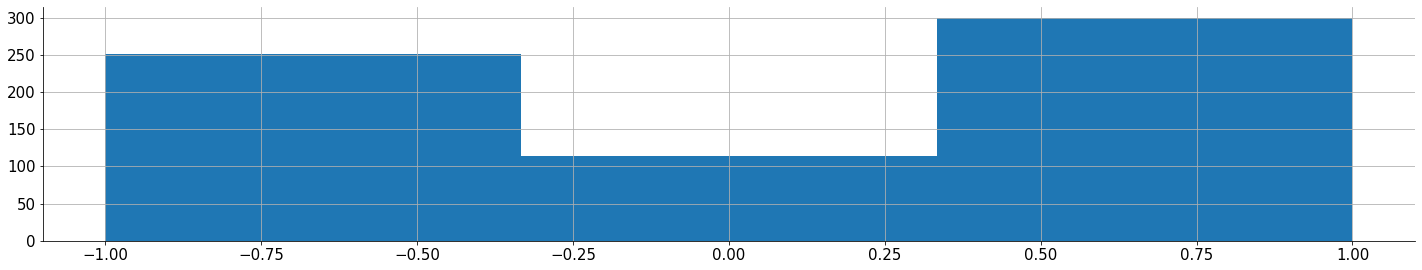

In [ ]:
hist = Uncertain_ID['Response'].hist(bins=3)
hist

In [ ]:
Uncertain_ID.set_index('Mouse_ID', inplace = True)

In [ ]:
Uncertain_ID = Uncertain_ID.reset_index()

# 5. Make an array of Mouse Names to index from, and set the index of the dataframe = MouseID (can change this)

In [ ]:
Mouse_Names = Uncertain_ID['Mouse_ID'].unique()

In [ ]:
Uncertain_ID = Uncertain_ID.set_index('Mouse_ID')

In [ ]:
Uncertain_ID.reset_index()


,Mouse_ID,index,Response,contrast_left,contrast_right,feedback_type,Time (ms),Session_ID,Previous_Resp1,Previous_Resp2,Previous_Resp3,Previous_Resp4,Previous_Left1,Previous_Left2,Previous_Left3,Previous_Left4,Previous_Right1,Previous_Right2,Previous_Right3,Previous_Right4,Previous_fdbk1,Previous_fdbk2,Previous_fdbk3,Previous_fdbk4,reaction_time,response_time,gocue,Strongest_Stim_Previous_1,Strongest_Stim_Previous_2,Strongest_Stim_Previous_3,Strongest_Stim_Previous_4,Prev_Resp1_Words,Response_Words,Previous_fdbk1_Words,Feedback_Words
0,Cori,17,-1.0,1.00,1.00,-1.0,170,0,0.0,-1.0,1.0,1.0,0.00,0.00,0.50,1.00,0.00,1.00,0.00,0.00,1.0,1.0,1.0,1.0,190.0,2.266866,0.988416,0.0,-1.0,1.0,1.0,None,Right,Reward,
1,Cori,48,-1.0,0.25,0.25,1.0,480,0,1.0,-1.0,-1.0,0.0,0.50,0.00,0.00,0.00,0.00,1.00,0.50,0.00,1.0,1.0,1.0,1.0,200.0,0.683524,0.550409,1.0,-1.0,-1.0,0.0,Left,Right,Reward,
2,Cori,54,1.0,0.50,0.50,1.0,540,0,1.0,0.0,-1.0,-1.0,1.00,0.00,0.00,0.00,0.25,0.00,0.00,1.00,1.0,1.0,-1.0,1.0,140.0,0.634664,0.508008,1.0,0.0,0.0,-1.0,Left,Left,Reward,
3,Cori,55,-1.0,0.50,0.50,1.0,550,0,1.0,1.0,0.0,-1.0,0.50,1.00,0.00,0.00,0.50,0.25,0.00,0.00,1.0,1.0,1.0,-1.0,210.0,1.134287,0.973215,0.0,1.0,0.0,0.0,Left,Right,Reward,
4,Cori,59,-1.0,0.50,0.50,-1.0,590,0,-1.0,-1.0,-1.0,-1.0,0.00,0.00,0.00,0.50,0.50,1.00,0.25,0.50,1.0,1.0,1.0,1.0,210.0,1.301291,0.750012,-1.0,-1.0,-1.0,0.0,Right,Right,Reward,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,Tatum,79,1.0,1.00,1.00,-1.0,790,37,1.0,1.0,-1.0,1.0,0.25,0.50,0.25,0.25,0.00,0.00,1.00,1.00,1.0,1.0,1.0,-1.0,190.0,1.351745,0.727463,1.0,1.0,-1.0,-1.0,Left,Left,Reward,
660,Tatum,80,1.0,1.00,1.00,-1.0,800,37,1.0,1.0,1.0,-1.0,1.00,0.25,0.50,0.25,1.00,0.00,0.00,1.00,-1.0,1.0,1.0,1.0,170.0,1.036357,0.657041,0.0,1.0,1.0,-1.0,Left,Left,,
661,Tatum,93,1.0,1.00,1.00,1.0,930,37,-1.0,0.0,-1.0,1.0,0.25,0.00,0.50,0.50,1.00,0.00,0.25,0.00,1.0,1.0,-1.0,1.0,250.0,0.693862,0.420538,-1.0,0.0,1.0,1.0,Right,Left,Reward,
662,Tatum,122,1.0,0.50,0.50,-1.0,1220,37,1.0,1.0,1.0,0.0,0.50,1.00,1.00,0.00,0.00,0.25,0.00,0.25,1.0,1.0,1.0,-1.0,180.0,0.743502,0.531187,1.0,1.0,1.0,-1.0,Left,Left,Reward,


# 6. Plot responses on the uncertain trials, by mouse

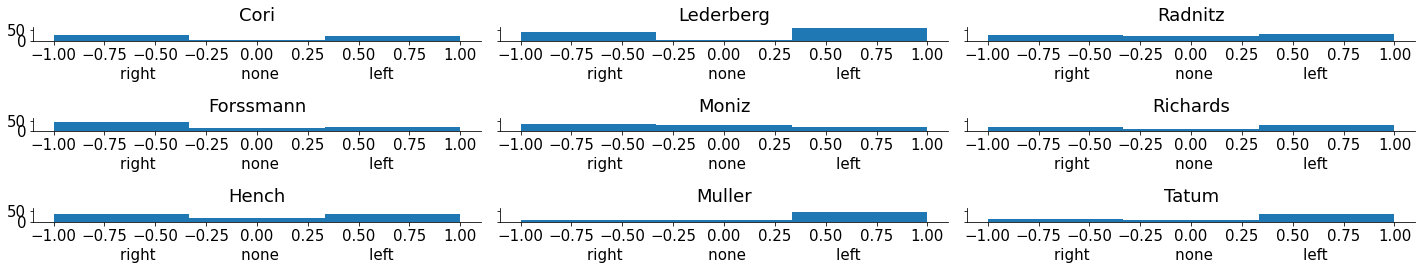

In [ ]:
fig, axs = plt.subplots(3, 3, sharey=True, tight_layout=True)

counter = 0

for i,name in enumerate(Mouse_Names):
  axs[i%3, int(i/3)].hist(Uncertain_ID.loc[name]['Response'],bins=3,)
  axs[i%3, int(i/3)].set_xlabel('right                  none                   left')
  axs[i%3, int(i/3)].set_title(name)
  counter+=1

In [ ]:
main_df = main_df.set_index('Mouse_ID')
Cori_L = np.round(np.sum((main_df.loc[Mouse_Names[0]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Cori_R = np.round(np.sum((main_df.loc[Mouse_Names[0]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Cori_N = np.round(np.sum((main_df.loc[Mouse_Names[0]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Lederberg_L = np.round(np.sum((main_df.loc[Mouse_Names[1]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Lederberg_R = np.round(np.sum((main_df.loc[Mouse_Names[1]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Lederberg_N = np.round(np.sum((main_df.loc[Mouse_Names[1]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Radnitz_L = np.round(np.sum((main_df.loc[Mouse_Names[2]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Radnitz_R = np.round(np.sum((main_df.loc[Mouse_Names[2]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Radnitz_N = np.round(np.sum((main_df.loc[Mouse_Names[2]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Forssman_L = np.round(np.sum((main_df.loc[Mouse_Names[3]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Forssman_R = np.round(np.sum((main_df.loc[Mouse_Names[3]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Forssman_N = np.round(np.sum((main_df.loc[Mouse_Names[3]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Moniz_L = np.round(np.sum((main_df.loc[Mouse_Names[4]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Moniz_R = np.round(np.sum((main_df.loc[Mouse_Names[4]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Moniz_N = np.round(np.sum((main_df.loc[Mouse_Names[4]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Richards_L = np.round(np.sum((main_df.loc[Mouse_Names[5]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Richards_R = np.round(np.sum((main_df.loc[Mouse_Names[5]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Richards_N = np.round(np.sum((main_df.loc[Mouse_Names[5]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Hench_L = np.round(np.sum((main_df.loc[Mouse_Names[6]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Hench_R = np.round(np.sum((main_df.loc[Mouse_Names[6]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Hench_N = np.round(np.sum((main_df.loc[Mouse_Names[6]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Muller_L = np.round(np.sum((main_df.loc[Mouse_Names[7]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Muller_R = np.round(np.sum((main_df.loc[Mouse_Names[7]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Muller_N = np.round(np.sum((main_df.loc[Mouse_Names[7]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Tatum_L = np.round(np.sum((main_df.loc[Mouse_Names[8]]['Previous_Resp1']==1)/len(main_df.loc[Mouse_Names[8]]['Previous_Resp1'])*100))
Tatum_R = np.round(np.sum((main_df.loc[Mouse_Names[8]]['Previous_Resp1']==-1)/len(main_df.loc[Mouse_Names[8]]['Previous_Resp1'])*100))
Tatum_N = np.round(np.sum((main_df.loc[Mouse_Names[8]]['Previous_Resp1']==0)/len(main_df.loc[Mouse_Names[8]]['Previous_Resp1'])*100))

print(f'Rounded Overall Choice Percentages:')
print(f'Cori overall percentages: {Cori_L}% left, {Cori_R}% right, {Cori_N}% neither')
print(f'Lederberg overall percentages: {Lederberg_L}% left, {Lederberg_R}% right, {Lederberg_N}% neither')
print(f'Radnitz overall percentages: {Radnitz_L}% left, {Radnitz_R}% right, {Radnitz_N}% neither')
print(f'Forssman overall percentages: {Forssman_L}% left, {Forssman_R}% right, {Forssman_N}% neither')
print(f'Moniz overall percentages: {Moniz_L}% left, {Moniz_R}% right, {Moniz_N}% neither')
print(f'Richards overall percentages: {Richards_L}% left, {Richards_R}% right, {Richards_N}% neither')
print(f'Hench overall percentages: {Hench_L}% left, {Hench_R}% right, {Hench_N}% neither')
print(f'Muller overall percentages: {Muller_L}% left, {Muller_R}% right, {Muller_N}% neither')
print(f'Tatum overall percentages: {Tatum_L}% left, {Tatum_R}% right, {Tatum_N}% neither')


Cori_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Cori_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Cori_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[0]]['Previous_Resp1'])*100))
Lederberg_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Lederberg_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Lederberg_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[1]]['Previous_Resp1'])*100))
Radnitz_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Radnitz_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Radnitz_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[2]]['Previous_Resp1'])*100))
Forssman_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Forssman_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Forssman_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[3]]['Previous_Resp1'])*100))
Moniz_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Moniz_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Moniz_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[4]]['Previous_Resp1'])*100))
Richards_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Richards_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Richards_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[5]]['Previous_Resp1'])*100))
Hench_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Hench_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Hench_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[6]]['Previous_Resp1'])*100))
Muller_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Muller_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Muller_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[7]]['Previous_Resp1'])*100))
Tatum_UL = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1']==1)/len(Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1'])*100))
Tatum_UR = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1']==-1)/len(Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1'])*100))
Tatum_UN = np.round(np.sum((Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1']==0)/len(Uncertain_ID.loc[Mouse_Names[8]]['Previous_Resp1'])*100))

print(f'')

print(f'Rounded Uncertain Trial Choice Percentages:')
print(f'Cori overall percentages: {Cori_UL}% left, {Cori_UR}% right, {Cori_UN}% neither')
print(f'Lederberg overall percentages: {Lederberg_UL}% left, {Lederberg_UR}% right, {Lederberg_UN}% neither')
print(f'Radnitz overall percentages: {Radnitz_UL}% left, {Radnitz_UR}% right, {Radnitz_UN}% neither')
print(f'Forssman overall percentages: {Forssman_UL}% left, {Forssman_UR}% right, {Forssman_UN}% neither')
print(f'Moniz overall percentages: {Moniz_UL}% left, {Moniz_UR}% right, {Moniz_UN}% neither')
print(f'Richards overall percentages: {Richards_UL}% left, {Richards_UR}% right, {Richards_UN}% neither')
print(f'Hench overall percentages: {Hench_UL}% left, {Hench_UR}% right, {Hench_UN}% neither')
print(f'Muller overall percentages: {Muller_UL}% left, {Muller_UR}% right, {Muller_UN}% neither')
print(f'Tatum overall percentages: {Tatum_UL}% left, {Tatum_UR}% right, {Tatum_UN}% neither')



Rounded Overall Choice Percentages:
Cori overall percentages: 30.0% left, 34.0% right, 36.0% neither
Lederberg overall percentages: 25.0% left, 38.0% right, 37.0% neither
Radnitz overall percentages: 40.0% left, 26.0% right, 34.0% neither
Forssman overall percentages: 38.0% left, 40.0% right, 22.0% neither
Moniz overall percentages: 27.0% left, 29.0% right, 43.0% neither
Richards overall percentages: 40.0% left, 26.0% right, 34.0% neither
Hench overall percentages: 28.0% left, 38.0% right, 35.0% neither
Muller overall percentages: 29.0% left, 32.0% right, 39.0% neither
Tatum overall percentages: 39.0% left, 29.0% right, 32.0% neither

Rounded Uncertain Trial Choice Percentages:
Cori overall percentages: 30.0% left, 36.0% right, 34.0% neither
Lederberg overall percentages: 24.0% left, 28.0% right, 47.0% neither
Radnitz overall percentages: 53.0% left, 24.0% right, 23.0% neither
Forssman overall percentages: 42.0% left, 34.0% right, 24.0% neither
Moniz overall percentages: 24.0% left, 34

In [ ]:
Uncertain_ID = Uncertain_ID.reset_index()
Certain_ID = Certain_ID.reset_index()

In [ ]:
Uncertain_ID['Bias_L_Overall'] = ['']*len(Uncertain_ID['Mouse_ID'])

for i in range(len((Uncertain_ID['Mouse_ID']))):
  if Uncertain_ID['Mouse_ID'][i] == 'Cori':
    Uncertain_ID['Bias_L_Overall'][i] = Cori_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Lederberg':
    Uncertain_ID['Bias_L_Overall'][i] = Lederberg_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Radnitz':
    Uncertain_ID['Bias_L_Overall'][i] = Radnitz_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Forssman':
    Uncertain_ID['Bias_L_Overall'][i] = Forssman_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Moniz':
    Uncertain_ID['Bias_L_Overall'][i] = Moniz_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Richards':
    Uncertain_ID['Bias_L_Overall'][i] = Richards_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Hench':
    Uncertain_ID['Bias_L_Overall'][i] = Hench_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Muller':
    Uncertain_ID['Bias_L_Overall'][i] = Muller_UL
  if Uncertain_ID['Mouse_ID'][i] == 'Tatum':
    Uncertain_ID['Bias_L_Overall'][i] = Tatum_UL

Certain_ID['Bias_L_Overall'] = ['']*len(Certain_ID['Mouse_ID'])

for i in range(len((Certain_ID['Mouse_ID']))):
  if Certain_ID['Mouse_ID'][i] == 'Cori':
    Certain_ID['Bias_L_Overall'][i] = Cori_UL
  if Certain_ID['Mouse_ID'][i] == 'Lederberg':
    Certain_ID['Bias_L_Overall'][i] = Lederberg_UL
  if Certain_ID['Mouse_ID'][i] == 'Radnitz':
    Certain_ID['Bias_L_Overall'][i] = Radnitz_UL
  if Certain_ID['Mouse_ID'][i] == 'Forssman':
    Certain_ID['Bias_L_Overall'][i] = Forssman_UL
  if Certain_ID['Mouse_ID'][i] == 'Moniz':
    Certain_ID['Bias_L_Overall'][i] = Moniz_UL
  if Certain_ID['Mouse_ID'][i] == 'Richards':
    Certain_ID['Bias_L_Overall'][i] = Richards_UL
  if Certain_ID['Mouse_ID'][i] == 'Hench':
    Certain_ID['Bias_L_Overall'][i] = Hench_UL
  if Certain_ID['Mouse_ID'][i] == 'Muller':
    Certain_ID['Bias_L_Overall'][i] = Muller_UL
  if Certain_ID['Mouse_ID'][i] == 'Tatum':
    Certain_ID['Bias_L_Overall'][i] = Tatum_UL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A val

# 7 Make 3 new mini-dataframes holding information about the uncertain trials on which the mouse: responded Left ('Left_UncertainID'); 2) responded Right('Right_UncertainID'); or 3) didn't Respond ('None_UncertainID')

In [ ]:
#Left animals
Left_UncertainID = Uncertain_ID[Uncertain_ID['Response'] == 1]
#Right animals
Right_UncertainID = Uncertain_ID[Uncertain_ID['Response'] == -1]
#None animals
None_UncertainID = Uncertain_ID[Uncertain_ID['Response'] == 0]

In [ ]:
#plt.hist(np.concatenate([Right_UncertainID['Strongest_Stim_Previous_1'],Right_UncertainID['Strongest_Stim_Previous_2'],Right_UncertainID['Strongest_Stim_Previous_3'],Right_UncertainID['Strongest_Stim_Previous_3'])
# create an index: +1 if left, -1 if right, for the previous trials
prev_response_index = (Uncertain_ID['Previous_Resp1']+Uncertain_ID['Previous_Resp2']+Uncertain_ID['Previous_Resp3']+Uncertain_ID['Previous_Resp4'])
#plt.plot(prev_response_index,Uncertain_ID['Response'],"o",alpha=.05)
counter = 0
Categ_by_Prev_Resp = []
for i in set(prev_response_index):
  Categ_by_Prev_Resp.append(np.mean(Uncertain_ID['Response'][prev_response_index==i]))
  
#plt.plot(set(prev_response_index),Categ_by_Prev_Resp)

# for each value of the index -- what is the proportion of L vs. proportion of R vs. proportion of Null


# ANALYSES

## Correlation

In [ ]:
corr_df = main_df[['Response','Previous_Resp1','Previous_Resp2','Previous_Resp3','Previous_Resp4']].copy()
corr_df.corr()

,Response,Previous_Resp1,Previous_Resp2,Previous_Resp3,Previous_Resp4
Response,1.000000,-0.004976,0.020907,0.030622,0.034007
Previous_Resp1,-0.004976,1.000000,-0.004354,0.022016,0.029296
Previous_Resp2,0.020907,-0.004354,1.000000,-0.005530,0.023117
Previous_Resp3,0.030622,0.022016,-0.005530,1.000000,-0.005208
Previous_Resp4,0.034007,0.029296,0.023117,-0.005208,1.000000


## Histograms

1. Overall, across all trials, what did the mice choose on the previous trial? (Made this plot just to compare to the uncertain trials plots)

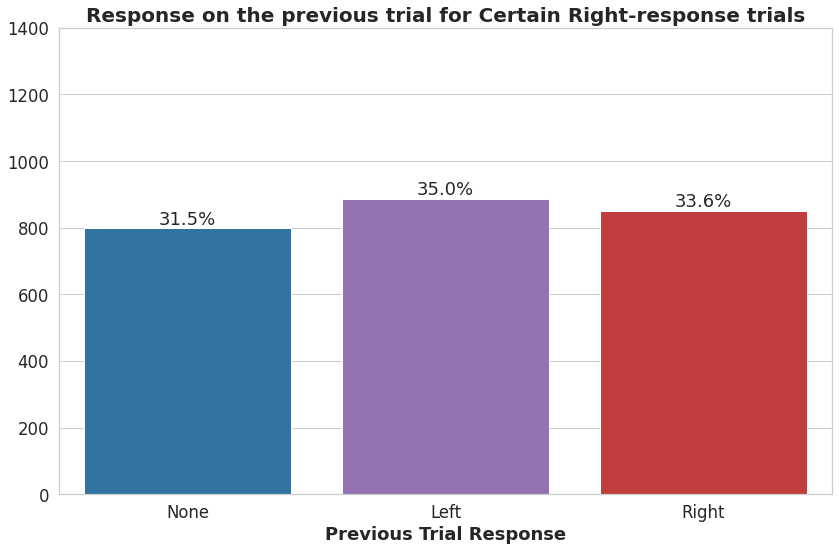

In [ ]:
main_R_trials_certain = main_df[(main_df['Response']==-1) & (main_df['contrast_left']!=main_df['contrast_right'])]
main_L_trials_certain = main_df[(main_df['Response']==1) & (main_df['contrast_left']!=main_df['contrast_right'])]

import seaborn as sns

sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
ax = sns.countplot(x="Prev_Resp1_Words",data=main_R_trials_certain,palette=("tab:blue","tab:purple","tab:red"),order=['None','Left','Right'])
#ax = sns.countplot(x="Prev_Resp1_Words",data=Right_UncertainID,palette=("tab:blue","tab:purple","tab:red"))

ax.set_title('Response on the previous trial for Certain Right-response trials',size=20,weight='bold')
ax.set_xlabel('Previous Trial Response',size=18,weight='bold')
ax.set_ylabel('')
ax.set_ylim((0,1400))
#ax.text(50, 850, ". Data: (1, 5)")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/len(main_R_trials_certain['Response'])), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

#plt.hist(main_R_trials['Previous_Resp1'],bins=5)
#plt.title('On all trials, what did the mouse choose on the last trial?')
import scipy
from scipy.stats import chi2_contingency


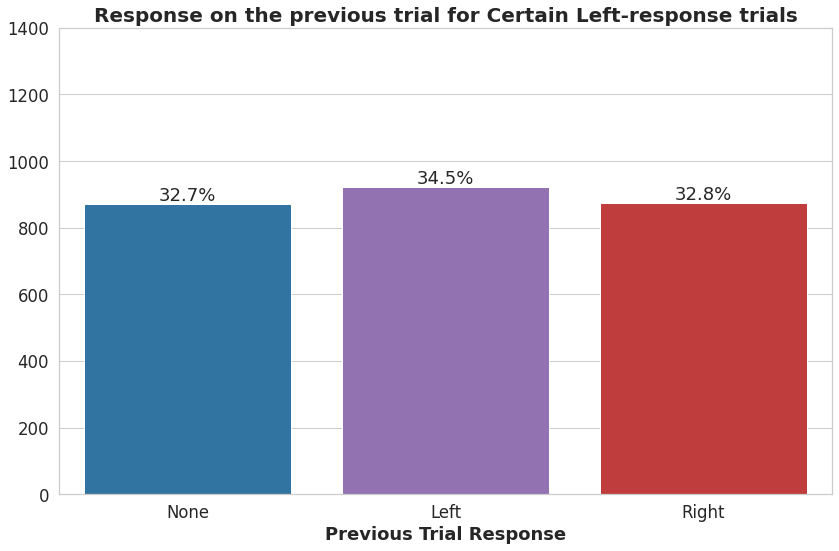

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
ax = sns.countplot(x="Prev_Resp1_Words",data=main_L_trials_certain,palette=("tab:blue","tab:purple","tab:red"),order=['None','Left','Right'])
#ax = sns.countplot(x="Prev_Resp1_Words",data=Right_UncertainID,palette=("tab:blue","tab:purple","tab:red"))

ax.set_title('Response on the previous trial for Certain Left-response trials',size=20,weight='bold')
ax.set_xlabel('Previous Trial Response',size=18,weight='bold')
ax.set_ylabel('')
ax.set_ylim((0,1400))
#ax.text(50, 850, ". Data: (1, 5)")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/len(main_L_trials_certain['Response'])), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

#plt.hist(main_R_trials['Previous_Resp1'],bins=5)
#plt.title('On all trials, what did the mouse choose on the last trial?')
import scipy
from scipy.stats import chi2_contingency

In [ ]:
L_prev_mainR_percent = sum(main_R_trials_certain['Prev_Resp1_Words']=='Left')/(len(main_R_trials_certain['Previous_Resp1']))
print(f'Percent Left choices on previous trial, certain Right trials: {L_prev_mainR_percent:.2f}')
R_prev_mainR_percent = sum(main_R_trials_certain['Prev_Resp1_Words']=='Right')/(len(main_R_trials_certain['Previous_Resp1']))
print(f'Percent Right choices on previous trial, certain Right trials: {R_prev_mainR_percent:.2f}')
N_prev_mainR_percent = sum(main_R_trials_certain['Prev_Resp1_Words']=='None')/(len(main_R_trials_certain['Previous_Resp1']))
print(f'Percent No choice on previous trial, certain Right trials: {N_prev_mainR_percent:.2f}')

L_prev_mainL_percent = sum(main_L_trials_certain['Prev_Resp1_Words']=='Left')/(len(main_L_trials_certain['Previous_Resp1']))
print(f'Percent Left choices on previous trial, certain Left trials: {L_prev_mainL_percent:.2f}')
R_prev_mainL_percent = sum(main_L_trials_certain['Prev_Resp1_Words']=='Right')/(len(main_L_trials_certain['Previous_Resp1']))
print(f'Percent Right choices on previous trial, certain Left trials: {R_prev_mainL_percent:.2f}')
N_prev_mainL_percent = sum(main_L_trials_certain['Prev_Resp1_Words']=='None')/(len(main_L_trials_certain['Previous_Resp1']))
print(f'Percent No choice on previous trial, certain Left trials: {N_prev_mainL_percent:.2f}')


Percent Left choices on previous trial, certain Right trials: 0.35
Percent Right choices on previous trial, certain Right trials: 0.34
Percent No choice on previous trial, certain Right trials: 0.31
Percent Left choices on previous trial, certain Left trials: 0.35
Percent Right choices on previous trial, certain Left trials: 0.33
Percent No choice on previous trial, certain Left trials: 0.33


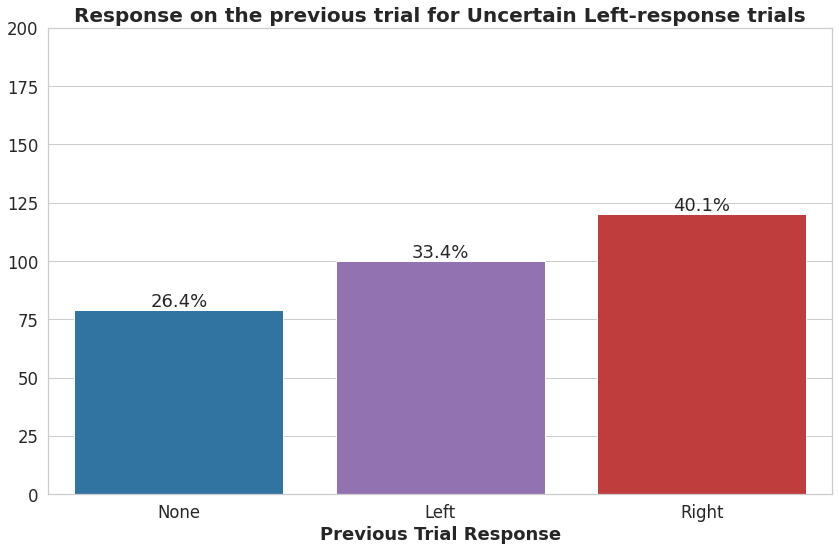

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
#ax = sns.countplot(x="Prev_Resp1_Words",data=main_R_trials_certain,palette=("tab:blue","tab:purple","tab:red"))
ax = sns.countplot(x="Prev_Resp1_Words",data=Left_UncertainID,palette=("tab:blue","tab:purple","tab:red"),order=['None','Left','Right'],)

ax.set_title('Response on the previous trial for Uncertain Left-response trials',size=20,weight='bold')
ax.set_xlabel('Previous Trial Response',size=18,weight='bold')
ax.set_ylabel('')
ax.set_ylim((0,200))


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/len(Left_UncertainID['Response'])), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

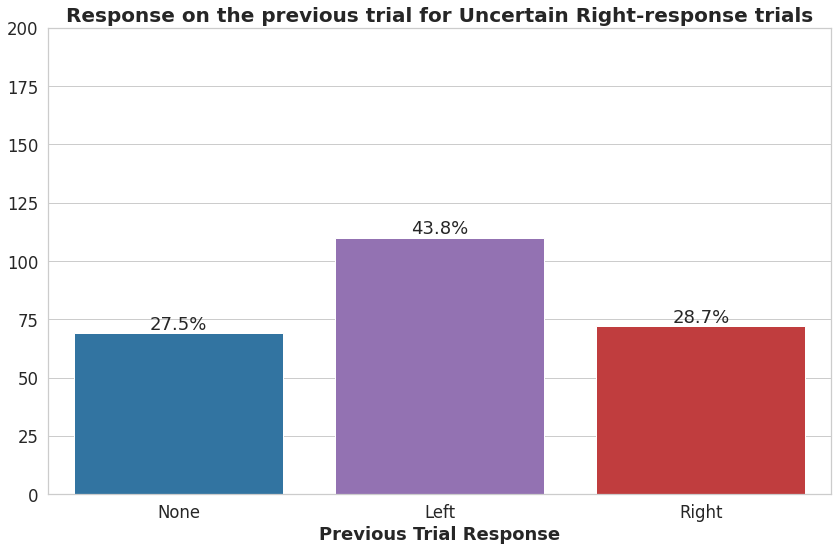

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)
sns.set_style("whitegrid") 
#ax = sns.countplot(x="Prev_Resp1_Words",data=main_R_trials_certain,palette=("tab:blue","tab:purple","tab:red"))
ax = sns.countplot(x="Prev_Resp1_Words",data=Right_UncertainID,palette=("tab:blue","tab:purple","tab:red"),order=['None','Left','Right'],)

ax.set_title('Response on the previous trial for Uncertain Right-response trials',size=20,weight='bold')
ax.set_xlabel('Previous Trial Response',size=18,weight='bold')
ax.set_ylabel('')
ax.set_ylim((0,200))

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/len(Right_UncertainID['Response'])), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

In [ ]:
L_prev_mainR_percent = sum(Right_UncertainID['Prev_Resp1_Words']=='Left')/(len(Right_UncertainID['Previous_Resp1']))
print(f'Percent Left choices on previous trial, certain Right trials: {L_prev_mainR_percent:.2f}')
R_prev_mainR_percent = sum(Right_UncertainID['Prev_Resp1_Words']=='Right')/(len(Right_UncertainID['Previous_Resp1']))
print(f'Percent Right choices on previous trial, certain Right trials: {R_prev_mainR_percent:.2f}')
N_prev_mainR_percent = sum(Right_UncertainID['Prev_Resp1_Words']=='None')/(len(Right_UncertainID['Previous_Resp1']))
print(f'Percent No choice on previous trial, certain Right trials: {N_prev_mainR_percent:.2f}')

L_prev_mainL_percent = sum(Left_UncertainID['Prev_Resp1_Words']=='Left')/(len(Left_UncertainID['Previous_Resp1']))
print(f'Percent Left choices on previous trial, certain Left trials: {L_prev_mainL_percent:.2f}')
R_prev_mainL_percent = sum(Left_UncertainID['Prev_Resp1_Words']=='Right')/(len(Left_UncertainID['Previous_Resp1']))
print(f'Percent Right choices on previous trial, certain Left trials: {R_prev_mainL_percent:.2f}')
N_prev_mainL_percent = sum(Left_UncertainID['Prev_Resp1_Words']=='None')/(len(Left_UncertainID['Previous_Resp1']))
print(f'Percent No choice on previous trial, certain Left trials: {N_prev_mainL_percent:.2f}')


Percent Left choices on previous trial, certain Right trials: 0.44
Percent Right choices on previous trial, certain Right trials: 0.29
Percent No choice on previous trial, certain Right trials: 0.27
Percent Left choices on previous trial, certain Left trials: 0.33
Percent Right choices on previous trial, certain Left trials: 0.40
Percent No choice on previous trial, certain Left trials: 0.26


2. Now, just looking at uncertain trials on which the mouse chose 'Right'. On the previous trial, what did they choose?

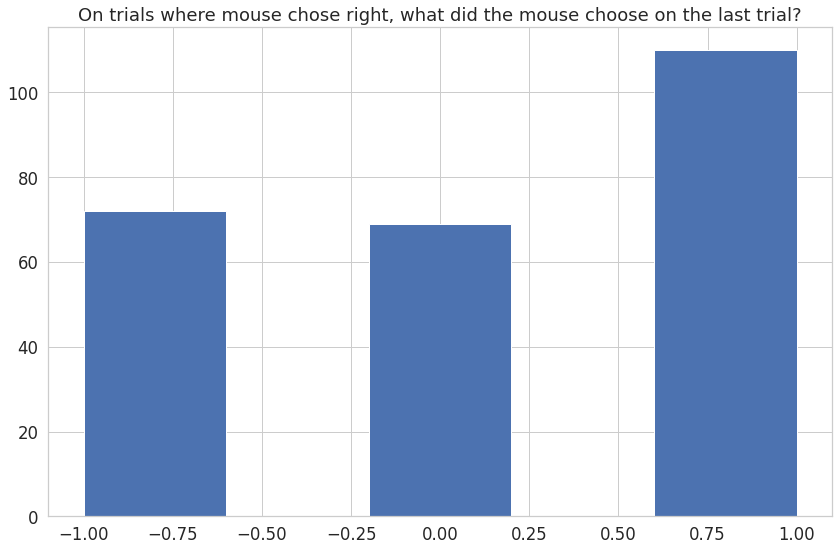

In [ ]:
#plt.hist((Right_UncertainID['Previous_Resp1']+.5*Right_UncertainID['Previous_Resp1']+.25*Right_UncertainID['Previous_Resp1']),bins=5)
#plt.hist(Reward_Last_Trial_UID['reaction_time'][np.isfinite(Reward_Last_Trial_UID['reaction_time'])],bins=5)
plt.hist(Right_UncertainID['Previous_Resp1'],bins=5)
plt.title('On trials where mouse chose right, what did the mouse choose on the last trial?');

In [ ]:
print(np.sum(Right_UncertainID['Previous_Resp1']==1)/len(Right_UncertainID['Previous_Resp1'])*100)
print(np.sum(Right_UncertainID['Previous_Resp1']==0)/len(Right_UncertainID['Previous_Resp1'])*100)
print(np.sum(Right_UncertainID['Previous_Resp1']==-1)/len(Right_UncertainID['Previous_Resp1'])*100)

43.82470119521912
27.490039840637447
28.68525896414343


2a. Assessing significance of above plot with a chi-square test!

In [ ]:
import scipy
from scipy import stats
scipy.stats.chisquare(Left_UncertainID['Previous_Resp1'].dropna(axis=0))
scipy.stats.chisquare()

Power_divergenceResult(statistic=-3269.0, pvalue=1.0)

# Chi-Square test to compare uncertain vs. certain trials

In [ ]:
Prev_resp_L_cert_L = np.sum(main_L_trials_certain['Previous_Resp1']==1)
Prev_resp_R_cert_L = np.sum(main_L_trials_certain['Previous_Resp1']==-1)
Prev_resp_N_cert_L = np.sum(main_L_trials_certain['Previous_Resp1']==0)

Prev_resp_L_uncert_L = np.sum(Left_UncertainID['Previous_Resp1']==1)
Prev_resp_R_uncert_L = np.sum(Left_UncertainID['Previous_Resp1']==-1)
Prev_resp_N_uncert_L = np.sum(Left_UncertainID['Previous_Resp1']==0)

#this should make a 2x3 contingency table -- group = rows, response = columns!
conting_table_L = np.array(((Prev_resp_L_cert_L, Prev_resp_R_cert_L, Prev_resp_N_cert_L),(Prev_resp_L_uncert_L, Prev_resp_R_uncert_L, Prev_resp_N_uncert_L)))

import scipy
from scipy import stats
chi2, p, dof, ex = scipy.stats.chi2_contingency(conting_table_L)

In [ ]:
print(chi2)
print(p)

7.704611335488089
0.021230728955666228


In [ ]:
Prev_resp_L_cert_R = np.sum(main_R_trials_certain['Previous_Resp1']==1)
Prev_resp_R_cert_R = np.sum(main_R_trials_certain['Previous_Resp1']==-1)
Prev_resp_N_cert_R = np.sum(main_R_trials_certain['Previous_Resp1']==0)

Prev_resp_L_uncert_R = np.sum(Right_UncertainID['Previous_Resp1']==1)
Prev_resp_R_uncert_R = np.sum(Right_UncertainID['Previous_Resp1']==-1)
Prev_resp_N_uncert_R = np.sum(Right_UncertainID['Previous_Resp1']==0)

#this should make a 2x3 contingency table -- group = rows, response = columns!
conting_table_R = np.array(((Prev_resp_L_cert_R, Prev_resp_R_cert_R, Prev_resp_N_cert_R),(Prev_resp_L_uncert_R, Prev_resp_R_uncert_R, Prev_resp_N_uncert_R)))

import scipy
from scipy import stats
chi2, p, dof, ex = scipy.stats.chi2_contingency(conting_table_R)

In [ ]:
print(chi2)
print(p)
print(np.shape(Left_UncertainID['Response']))
print(np.shape(main_L_trials_certain['Response']))

7.796415707371606
0.020278220438590018
(299,)
(2666,)


In [ ]:
Right_UncertainID

,Mouse_ID,index,Response,contrast_left,contrast_right,feedback_type,Time (ms),Session_ID,Previous_Resp1,Previous_Resp2,Previous_Resp3,Previous_Resp4,Previous_Left1,Previous_Left2,Previous_Left3,Previous_Left4,Previous_Right1,Previous_Right2,Previous_Right3,Previous_Right4,Previous_fdbk1,Previous_fdbk2,Previous_fdbk3,Previous_fdbk4,reaction_time,response_time,gocue,Strongest_Stim_Previous_1,Strongest_Stim_Previous_2,Strongest_Stim_Previous_3,Strongest_Stim_Previous_4,Prev_Resp1_Words,Response_Words,Previous_fdbk1_Words,Feedback_Words,Bias_L_Overall
0,Cori,17,-1.0,1.00,1.00,-1.0,170,0,0.0,-1.0,1.0,1.0,0.00,0.00,0.50,1.0,0.0,1.00,0.00,0.00,1.0,1.0,1.0,1.0,190.0,2.266866,0.988416,0.0,-1.0,1.0,1.0,None,Right,Reward,,30
1,Cori,48,-1.0,0.25,0.25,1.0,480,0,1.0,-1.0,-1.0,0.0,0.50,0.00,0.00,0.0,0.0,1.00,0.50,0.00,1.0,1.0,1.0,1.0,200.0,0.683524,0.550409,1.0,-1.0,-1.0,0.0,Left,Right,Reward,,30
3,Cori,55,-1.0,0.50,0.50,1.0,550,0,1.0,1.0,0.0,-1.0,0.50,1.00,0.00,0.0,0.5,0.25,0.00,0.00,1.0,1.0,1.0,-1.0,210.0,1.134287,0.973215,0.0,1.0,0.0,0.0,Left,Right,Reward,,30
4,Cori,59,-1.0,0.50,0.50,-1.0,590,0,-1.0,-1.0,-1.0,-1.0,0.00,0.00,0.00,0.5,0.5,1.00,0.25,0.50,1.0,1.0,1.0,1.0,210.0,1.301291,0.750012,-1.0,-1.0,-1.0,0.0,Right,Right,Reward,,30
5,Cori,66,-1.0,0.25,0.25,-1.0,660,0,-1.0,1.0,-1.0,0.0,0.00,1.00,0.00,0.0,0.5,0.00,0.50,0.00,1.0,1.0,1.0,1.0,250.0,1.984788,1.152418,-1.0,1.0,-1.0,0.0,Right,Right,Reward,,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,Tatum,253,-1.0,1.00,1.00,-1.0,2530,34,-1.0,-1.0,-1.0,1.0,0.25,1.00,0.25,1.0,1.0,0.50,1.00,0.25,1.0,-1.0,1.0,1.0,230.0,1.866947,0.785449,-1.0,1.0,-1.0,1.0,Right,Right,Reward,,38
618,Tatum,268,-1.0,1.00,1.00,-1.0,2680,34,-1.0,-1.0,0.0,1.0,0.25,0.25,0.00,0.0,1.0,1.00,0.00,0.00,1.0,1.0,1.0,-1.0,220.0,0.871404,0.735066,-1.0,-1.0,0.0,0.0,Right,Right,Reward,,38
633,Tatum,161,-1.0,0.50,0.50,-1.0,1610,35,0.0,-1.0,-1.0,1.0,0.00,0.00,0.00,0.5,0.0,0.50,1.00,1.00,1.0,1.0,1.0,-1.0,450.0,1.233608,0.586470,0.0,-1.0,-1.0,-1.0,None,Right,Reward,,38
639,Tatum,222,-1.0,1.00,1.00,1.0,2220,35,1.0,-1.0,0.0,1.0,1.00,0.50,0.00,1.0,0.5,1.00,0.00,0.00,1.0,1.0,1.0,1.0,370.0,1.015825,0.535752,1.0,-1.0,0.0,1.0,Left,Right,Reward,,38


3. Now, just looking at uncertain trials on which the mouse chose 'Left'. On the previous trial, what did they choose?

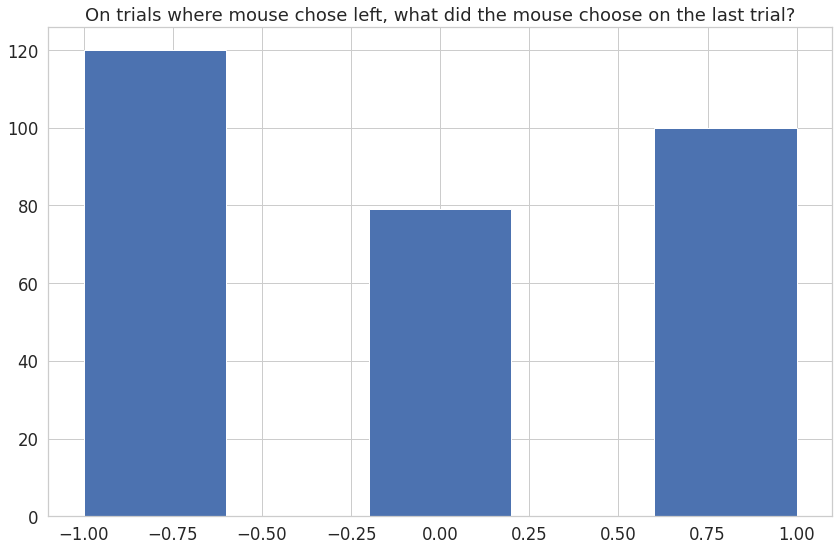

In [ ]:
plt.hist(Left_UncertainID['Previous_Resp1'],bins=5)
plt.title('On trials where mouse chose left, what did the mouse choose on the last trial?');

In [ ]:
print(np.sum(Left_UncertainID['Previous_Resp1']==1)/len(Left_UncertainID['Previous_Resp1'])*100)
print(np.sum(Left_UncertainID['Previous_Resp1']==0)/len(Left_UncertainID['Previous_Resp1'])*100)
print(np.sum(Left_UncertainID['Previous_Resp1']==-1)/len(Left_UncertainID['Previous_Resp1'])*100)

33.44481605351171
26.421404682274247
40.13377926421405


3a. Assessing significance of above plot with a chi-square test!


In [ ]:
import scipy
from scipy import stats
scipy.stats.chisquare(Left_UncertainID['Previous_Resp1'].dropna(axis=0))

Power_divergenceResult(statistic=-3269.0, pvalue=1.0)

4. Now, just looking at uncertain trials on which the mouse made no choice. On the previous trial, what did they choose?

(array([51.,  0., 29.,  0., 34.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <a list of 5 Patch objects>)

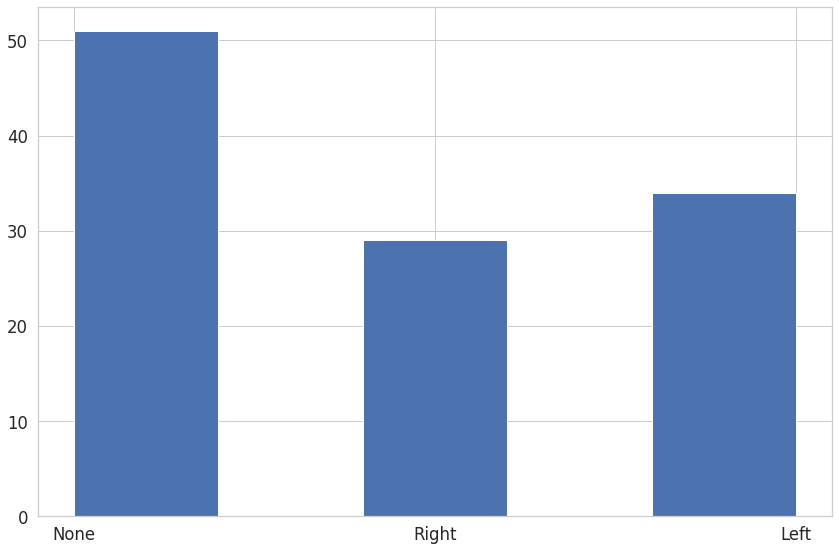

In [ ]:
plt.hist(None_UncertainID['Prev_Resp1_Words'],bins=5)

In [ ]:
print(np.sum(None_UncertainID['Previous_Resp1']==1)/len(None_UncertainID['Previous_Resp1'])*100)
print(np.sum(None_UncertainID['Previous_Resp1']==0)/len(None_UncertainID['Previous_Resp1'])*100)
print(np.sum(None_UncertainID['Previous_Resp1']==-1)/len(None_UncertainID['Previous_Resp1'])*100)

29.82456140350877
44.73684210526316
25.438596491228072


3a. Assessing significance of above plot with a chi-square test!


In [ ]:
scipy.stats.chisquare(Left_UncertainID['Previous_Resp1'].dropna(axis=0))

Power_divergenceResult(statistic=-3269.0, pvalue=1.0)

(array([6., 0., 6., 0., 9.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <a list of 5 Patch objects>)

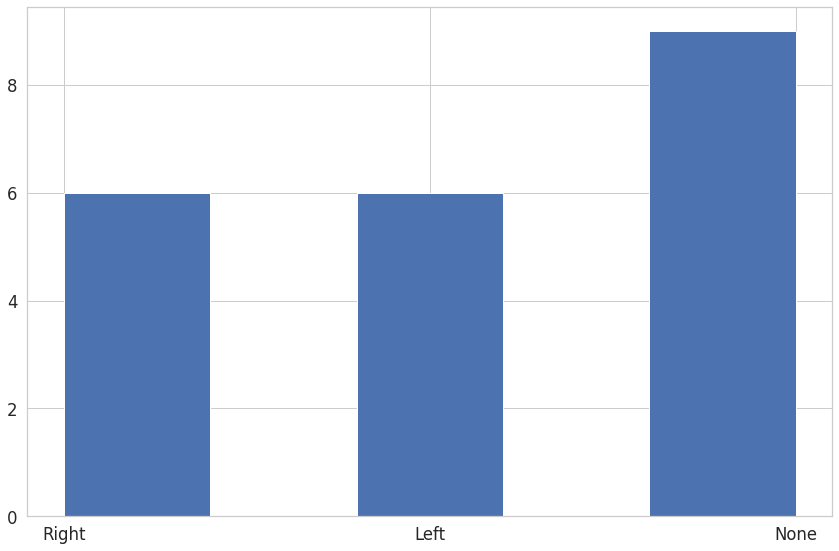

In [ ]:
Reward_Last_Trial_UID = Uncertain_ID[Uncertain_ID['Previous_fdbk1']==-1]
Right_Reward_Last_Trial_UID = Reward_Last_Trial_UID[Reward_Last_Trial_UID['Previous_Resp1']==-1]
plt.hist(Right_Reward_Last_Trial_UID['Response_Words'],bins=5)

In [ ]:
Reward_Last_Trial_UID = Uncertain_ID[Uncertain_ID['Previous_fdbk1']==1]
Reward_Last_Trial_UID = Reward_Last_Trial_UID[Reward_Last_Trial_UID['Previous_Resp1']==-1]


## Logistic Regression

In [ ]:
Uncertain_ID = Uncertain_ID.dropna(axis=0)

In [ ]:
#Uncertain_ID['Bias_L_Overall'] = Uncertain_ID['Bias_L_Overall'].astype(float)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# create design matrix
# variables of interest: previous response (potentially multiple trials back?); reward feedback on previous trial; mouse choice bias overall

Response_dummy = pd.get_dummies(Uncertain_ID['Previous_Resp1'])
Feedback_dummy = pd.get_dummies(Uncertain_ID['Feedback_Words'])

Design_Matrix = pd.concat((Response_dummy,Feedback_dummy),axis=1)
#Design_Matrix = Response_dummy
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(logmodel, Design_Matrix, Uncertain_ID['Response'], scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
a = logmodel.fit(Design_Matrix,Uncertain_ID['Response'])
#predictions = logmodel.predict(X_test)

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.460 (0.046)


In [ ]:
shuffled_responses = Uncertain_ID['Response']
np.random.shuffle(shuffled_responses)

shuffled_responses
print(shuffled_responses)

0      1.0
1     -1.0
2     -1.0
3      0.0
4      1.0
      ... 
659   -1.0
660    1.0
661    1.0
662    1.0
663   -1.0
Name: Response, Length: 664, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(Design_Matrix, Uncertain_ID['Response'],train_size=0.8)

#X, y = load_iris(return_X_y=True)
logmodel = LogisticRegression(multi_class= 'multinomial',random_state=0).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

#print(logmodel.coef_)

# 3 IV classes
# -1 0 1
# {Right Prev} {None Prev} {Left Prev}
# 4 predictor columns --> 1 dv with 3 levels and 1 with 2 levels
# can add an interaction term to a logistic regression?

0.46616541353383456

In [ ]:
filtered_spks_prev_all, filtered_labels_prev_all, filtered_spks_current_all, filtered_labels_current_all

NameError: ignored

In [ ]:
np.shape(filtered_labels_prev_all)

In [ ]:
np.shape(filtered_labels_current_all)

In [ ]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

n_scores = []

for i in range(1):
  # create dummy variables, and their interactions
  # figure out whether we want to look at Certain trials only, or the whole data frame for the comparison
  # y, X = dmatrices('Response ~ C(Previous_Resp1)', Uncertain_ID, return_type="dataframe")
  #y, X = dmatrices('Response ~ C(Previous_Resp1)*Previous_fdbk1 + C(Previous_Resp2)*Previous_fdbk2 + C(Previous_Resp3)*Previous_fdbk3 + C(Previous_Resp4)*Previous_fdbk4', LorR_Uncertain_ID, return_type="dataframe")

  # flatten y into a 1-D array so scikit-learn can understand it
  # y = np.ravel(y)
  train_x, test_x, train_y, test_y = train_test_split(Design_Matrix, Uncertain_ID['Response'], train_size=0.8)

  logmodel = LogisticRegression(multi_class= 'multinomial', random_state=0, max_iter = 500).fit(train_x, train_y)
  logmodel.predict(test_x)
  logmodel.predict_proba(test_x)
  logmodel.score(test_x,test_y)

  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


In [ ]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split

LorR_Uncertain_ID = Uncertain_ID.loc[(Uncertain_ID['Response']==-1) | (Uncertain_ID['Response']==1)]

n_scores = []

for i in range(1):
  # create dummy variables, and their interactions
  # figure out whether we want to look at Certain trials only, or the whole data frame for the comparison
  y, X = dmatrices('Response_or_Not ~ C(Previous_Resp1)', Uncertain_ID, return_type="dataframe")
  #y, X = dmatrices('Response ~ C(Previous_Resp1)*Previous_fdbk1 + C(Previous_Resp2)*Previous_fdbk2 + C(Previous_Resp3)*Previous_fdbk3 + C(Previous_Resp4)*Previous_fdbk4', LorR_Uncertain_ID, return_type="dataframe")

  # flatten y into a 1-D array so scikit-learn can understand it
  y = np.ravel(y)
  train_x, test_x, train_y, test_y = train_test_split(X, y,train_size=0.8)

  logmodel = LogisticRegression(multi_class= 'multinomial', random_state=0, max_iter = 500).fit(train_x, train_y)
  logmodel.predict(test_x)
  logmodel.predict_proba(test_x)
  logmodel.score(test_x,test_y)

  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


In [ ]:
from sklearn import preprocessing
Bias_L_Overall = train_x[['Bias_L_Overall']]

scaler = preprocessing.StandardScaler().fit(Bias_L_Overall)
train_x['Bias_L_Overall'] = scaler.transform(Bias_L_Overall)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split


Response_dummy = pd.get_dummies(Uncertain_ID['Previous_Resp1'])
Feedback_dummy = pd.get_dummies(Uncertain_ID['Previous_fdbk1'])
Int_dummy = pd.get_dummies(Uncertain_ID['Previous_fdbk1'])

#Int_dummy = pd.get_dummies(Uncertain_ID['Previous_Resp1']*Uncertain_ID['Previous_fdbk1'])

Design_Matrix = pd.concat((Response_dummy,Feedback_dummy,Int_dummy),axis=1)

train_x, test_x, train_y, test_y = train_test_split(Design_Matrix, Uncertain_ID['Response'],train_size=0.8)

#X, y = load_iris(return_X_y=True)
logmodel = LogisticRegression(multi_class= 'multinomial', random_state=0).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

#print(logmodel.coef_)

# 3 IV classes
# -1 0 1
# {Right Prev} {None Prev} {Left Prev}
# 4 predictor columns --> 1 dv with 3 levels and 1 with 2 levels
# can add an interaction term to a logistic regression?


# GLM

In [ ]:
main_df[main_df['contrast_left']==0]

In [ ]:
LorR_Uncertain_ID

In [ ]:
LorR_Uncertain_ID['Response'].unique()

In [ ]:
# We will make 2 separate GLMs
# One will have a response variable of Left or Right
# One will have a response variable of Choice or No Choice

# First, Left or Right
LorR_Uncertain_ID = Uncertain_ID.loc[(Uncertain_ID['Response']==-1) | (Uncertain_ID['Response']==1)]

#Recreate design Matrix
Response_dummy = pd.get_dummies(LorR_Uncertain_ID['Previous_Resp1'])
Feedback_dummy = pd.get_dummies(LorR_Uncertain_ID['Feedback_Words'])

Design_Matrix = pd.concat((Response_dummy,Feedback_dummy),axis=1)

LorR_Resp_Flipped = LorR_Uncertain_ID['Response']*-1
# Make the first GLM
# the thing we are predicting is LorR_Uncertain_ID['Response'], our predictors are previous response, reward feedback, overall bias
import statsmodels.api as sm
from statsmodels import tools
Design_Matrix['intercept'] = 1
gl_model = sm.GLM(LorR_Uncertain_ID['Response'], Design_Matrix, family=sm.families.Binomial())

res = gl_model.fit()
print(res.summary())


In [ ]:
print('Parameters: ', res.params)
print('T-values: ', res.tvalues)

In [ ]:
nobs = res.nobs
y = LorR_Uncertain_ID['Response']
yhat = res.mu
from statsmodels.graphics.api import abline_plot
fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

In [ ]:
# Next, we need to make a column that codes 1 if L or R response was made, and 0 if no response was made
Uncertain_ID['Response_or_Not'] = np.zeros(len(Uncertain_ID['Response']))
for i in range(len(Uncertain_ID['Response'])):
  if Uncertain_ID['Response'][i] == -1:
    Uncertain_ID['Response_or_Not'][i] = 1
  elif Uncertain_ID['Response'][i] == 1:
    Uncertain_ID['Response_or_Not'][i] = 1
  elif Uncertain_ID['Response'][i] == 0:
    Uncertain_ID['Response_or_Not'][i] = 0

# Neural Data

Original code we wrote with Michael

In [ ]:
# choose the brain region of interest
region = 'ILA'

# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high


for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0 
  spks_avg.append(l[:,np.logical_and(i>k, k<i)].mean(axis=1))

Isobel exploring

In [ ]:
spks_avg_uc = []
spks_avg_LgR = []
spks_avg_RgL = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_avg_uc.append(l[:,np.logical_and(np.logical_and(i==k, j==j),k!=0)].mean(axis=1))
  #print(spks_avg_uc)
for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0 
  spks_avg_LgR.append(np.nanmean(l[:,np.logical_and(i>k, j==j)],axis=1))
for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0 
  spks_avg_RgL.append(l[:,np.logical_and(i<k, j==j)].mean(axis=1))
#plt.plot(np.vstack(spks_avg_uc).mean(axis=0), 'r')
  #take the nanmean for uncertain trials bc there is often a nan array
plt.plot(np.nanmean(np.vstack(spks_avg_uc),axis=0), 'r')
plt.plot(np.vstack(spks_avg_LgR).mean(axis=0), 'b')
plt.plot(np.vstack(spks_avg_RgL).mean(axis=0), 'g')

In [ ]:
spks_uc_prev = []
spks_uc = []
spks_all = []
spks_cert = []
uc_trial_response = []
cert_trial_response = []
trial_response_all = []
uc_or_cert_idx = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_uc_prev.append(l[:,np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])
  spks_uc.append(l[:,np.logical_and(np.logical_and(i==k, j==j),k!=0)])
  spks_cert.append(l[:,np.logical_and(i!=k,k!=i)])
  spks_all.append(l)

  print(sum(np.logical_and(np.logical_and(i==k, j==j),k!=0)))
  #uc_trial_response.append(j[np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])
  uc_trial_response.append(j[np.logical_and(np.logical_and(i==k, j==j),k!=0)])
  uc_or_cert_idx.append(np.logical_and(i==k,k!=0).astype(int))
  cert_trial_response.append(j[np.logical_and(i!=k, k!=i)])
  # here need to create a running index for certain vs. uncertain trials
  trial_response_all.append(j)

  #print(spks_avg_uc)


In [ ]:
array_spks = []
array_idx = []
for i in range(len(spks_uc_prev)):
  if spks_uc_prev[i].size!=0:
    a = np.vstack(spks_uc_prev[i])
    b = np.vstack(np.repeat(uc_trial_response[i],np.shape(spks_uc_prev[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_prev_all = np.vstack(array_spks)
idx_uc_prev_all = np.vstack(array_idx)

for i in range(len(spks_uc)):
  if spks_uc[i].size!=0:
    a = np.vstack(spks_uc[i])
    b = np.vstack(np.repeat(uc_trial_response[i],np.shape(spks_uc[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_all = np.vstack(array_spks)
idx_uc_all = np.vstack(array_idx)


for i in range(len(spks_cert)):
  if spks_cert[i].size!=0:
    a = np.vstack(spks_cert[i])
    b = np.vstack(np.repeat(cert_trial_response[i],np.shape(spks_cert[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_cert_all = np.vstack(array_spks)
idx_cert_all = np.vstack(array_idx)

for i in range(len(spks_all)):
  if spks_all[i].size!=0:
    a = np.vstack(spks_all[i])
    b = np.vstack(np.repeat(uc_or_cert_idx[i],np.shape(spks_all[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks = np.vstack(array_spks)
idx_all = np.vstack(array_idx)

In [ ]:
spks_uc_prev_all_right_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==-1]
spks_uc_prev_all_left_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==1]
spks_uc_prev_all_none_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== 0]


In [ ]:
plt.plot(np.mean(spks_uc_prev_all_right_current,axis=0),'r');
plt.plot(np.mean(spks_uc_prev_all_left_current,axis=0),'b');
plt.plot(np.mean(spks_uc_prev_all_none_current,axis=0),'g');

In [ ]:
np.shape(spks_uc_prev_all[:,0:50])

In [ ]:
# Define the model
log_reg = LogisticRegression(penalty="none",multi_class='multinomial', solver='lbfgs')

# Fit it to data
log_reg.fit(spks_uc_prev_all[:,0:50], idx_uc_prev_all)

def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(spks_uc_prev_all[:,0:50])

  accuracy = (idx_all == y_pred).mean()

  return accuracy


# Compute train accurcy
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

In [ ]:
np.shape(idx_all)

Original code we wrote with Michael

In [ ]:
#Average over the trials
plt.plot(np.vstack(spks_avg).mean(axis=0))

In [ ]:
visr_ls[0][2]
response_ls[0][2]

## PCA

## Code from tutorial 3

In [ ]:
# choose the brain region of interest
region = 'CP'

# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_prev = []
uc_trial_response = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_uc_prev.append(l[:,np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])
  print(sum(np.logical_and(np.logical_and(i==k, j==j),k!=0)))
  uc_trial_response.append(j[np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])

array_spks = []
array_idx = []
for i in range(len(spks_uc_prev)):
  if spks_uc_prev[i].size!=0:
    a = np.vstack(spks_uc_prev[i])
    b = np.vstack(np.repeat(uc_trial_response[i],np.shape(spks_uc_prev[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_prev_all = np.vstack(array_spks)
idx_uc_prev_all = np.vstack(array_idx)

spks_uc_prev_all_right_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==-1]
spks_uc_prev_all_left_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==1]
spks_uc_prev_all_none_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== 0]

plt.plot(np.mean(spks_uc_prev_all_right_current,axis=0),'r');
plt.plot(np.mean(spks_uc_prev_all_left_current,axis=0),'b');
plt.plot(np.mean(spks_uc_prev_all_none_current,axis=0),'g');



In [ ]:
# choose the brain region of interest
region = 'CP'

# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

In [ ]:
spks_uc_prev = []
uc_trial_response = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_uc_prev.append(l[:,np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])
  print(sum(np.logical_and(np.logical_and(i==k, j==j),k!=0)))
  uc_trial_response.append(j[np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])

In [ ]:
array_spks = []
array_idx = []
for i in range(len(spks_uc_prev)):
  if spks_uc_prev[i].size!=0:
    a = np.vstack(spks_uc_prev[i])
    b = np.vstack(np.repeat(uc_trial_response[i],np.shape(spks_uc_prev[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_prev_all = np.vstack(array_spks)
idx_uc_prev_all = np.vstack(array_idx)

In [ ]:
spks_uc_prev_all_right_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==-1]
spks_uc_prev_all_left_current = spks_uc_prev_all[idx_uc_prev_all[:,0]==1]
spks_uc_prev_all_none_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== 0]

In [ ]:
plt.plot(np.mean(spks_uc_prev_all_right_current,axis=0),'r');
plt.plot(np.mean(spks_uc_prev_all_left_current,axis=0),'b');
plt.plot(np.mean(spks_uc_prev_all_none_current,axis=0),'g');

In [ ]:
spks_uc = []
spks_LgR = []
spks_RgL = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  spks_uc.append(l[:,np.logical_and(np.logical_and(i==k, k!=0), j==-1)].mean(axis=1))
for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0 
  spks_LgR.append(l[:,np.logical_and(i>k, k<i)].mean(axis=1))
for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0 
  spks_RgL.append(l[:,np.logical_and(i<k, i<k)].mean(axis=1))

In [ ]:
# @title Plotting Functions

def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()


def plot_MNIST_reconstruction(X, X_reconstructed):
  """
  Plots 9 images in the MNIST dataset side-by-side with the reconstructed
  images.

  Args:
    X (numpy array of floats)               : Data matrix each column
                                              corresponds to a different
                                              random variable
    X_reconstructed (numpy array of floats) : Data matrix each column
                                              corresponds to a different
                                              random variable

  Returns:
    Nothing.
  """

  plt.figure()
  ax = plt.subplot(121)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.title('Data')
  plt.clim([0, 250])
  ax = plt.subplot(122)
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(np.real(X_reconstructed[k, :]), (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2 + 1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.clim([0, 250])
  plt.title('Reconstructed')
  plt.tight_layout()


def plot_MNIST_sample(X):
  """
  Plots 9 images in the MNIST dataset.

  Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable

  Returns:
    Nothing.

  """

  fig, ax = plt.subplots()
  k = 0
  for k1 in range(3):
    for k2 in range(3):
      k = k + 1
      plt.imshow(np.reshape(X[k, :], (28, 28)),
                 extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                 vmin=0, vmax=255)
  plt.xlim((3 * 28, 0))
  plt.ylim((3 * 28, 0))
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim([0, 250])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_MNIST_weights(weights):
  """
  Visualize PCA basis vector weights for MNIST. Red = positive weights,
  blue = negative weights, white = zero weight.

  Args:
     weights (numpy array of floats) : PCA basis vector

  Returns:
     Nothing.
  """

  fig, ax = plt.subplots()
  cmap = plt.cm.get_cmap('seismic')
  plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
  plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
  plt.clim(-.15, .15)
  plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


def plot_eigenvalues(evals, limit=True):
  """
  Plots eigenvalues.

  Args:
     (numpy array of floats) : Vector of eigenvalues

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
  plt.xlabel('Component')
  plt.ylabel('Eigenvalue')
  plt.title('Scree plot')
  if limit:
    plt.show()

In [ ]:
# @title Helper Functions

def add_noise(X, frac_noisy_pixels):
  """
  Randomly corrupts a fraction of the pixels by setting them to random values.

  Args:
     X (numpy array of floats)  : Data matrix
     frac_noisy_pixels (scalar) : Fraction of noisy pixels

  Returns:
     (numpy array of floats)    : Data matrix + noise

  """

  X_noisy = np.reshape(X, (X.shape[0] * X.shape[1]))
  N_noise_ixs = int(X_noisy.shape[0] * frac_noisy_pixels)
  noise_ixs = np.random.choice(X_noisy.shape[0], size=N_noise_ixs,
                               replace=False)
  X_noisy[noise_ixs] = np.random.uniform(0, 255, noise_ixs.shape)
  X_noisy = np.reshape(X_noisy, (X.shape[0], X.shape[1]))

  return X_noisy


def change_of_basis(X, W):
  """
  Projects data onto a new basis.

  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors

  Returns:
    (numpy array of floats)   : Data matrix expressed in new basis
  """

  Y = np.matmul(X, W)

  return Y


def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X.

  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable

  Returns:
    (numpy array of floats)   : Covariance matrix
"""

  X = X - np.mean(X, 0)
  cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)
  return cov_matrix


def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    :   Vector of eigenvalues
    evectors (numpy array of floats) :   Corresponding matrix of eigenvectors
                                         each column corresponds to a different
                                         eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2)*np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]

  return evals, evectors


def pca(X):
  """
  Performs PCA on multivariate data. Eigenvalues are sorted in decreasing order

  Args:
     X (numpy array of floats) :   Data matrix each column corresponds to a
                                   different random variable

  Returns:
    (numpy array of floats)    : Data projected onto the new basis
    (numpy array of floats)    : Vector of eigenvalues
    (numpy array of floats)    : Corresponding matrix of eigenvectors

  """

  X = X - np.mean(X, 0)
  cov_matrix = get_sample_cov_matrix(X)
  evals, evectors = np.linalg.eigh(cov_matrix)
  evals, evectors = sort_evals_descending(evals, evectors)
  score = change_of_basis(X, evectors)

  return score, evectors, evals

In [ ]:
#creating an array of all spks
spks_all = np.vstack((np.vstack((spks_uc_prev_all_right_current, spks_uc_prev_all_left_current)), spks_uc_prev_all_none_current))

In [ ]:
#creating an array of all spks
spks_all = np.vstack((np.vstack((spks_uc_prev_all_right_current, spks_uc_prev_all_left_current)), spks_uc_prev_all_none_current))

# Creating an array of the labels
label_spks_uc_prev_all_right_current = np.array([-1]*len(spks_uc_prev_all_right_current))
label_spks_uc_prev_all_left_current = np.array([1]*len(spks_uc_prev_all_left_current))
label_spks_uc_prev_all_none_current = np.array([0]*len(spks_uc_prev_all_none_current))
label_all = np.hstack((np.hstack((label_spks_uc_prev_all_right_current, label_spks_uc_prev_all_left_current)),label_spks_uc_prev_all_none_current))

In [ ]:
# Perform PCA
score, evectors, evals = pca(spks_all)

# Plot the eigenvalues
plot_eigenvalues(evals, limit=False)
plt.xlim([0, 100])  # limit x-axis up to 100 for zooming

In [ ]:

def get_variance_explained(evals):
  """
  Calculates variance explained from the eigenvalues.

  Args:
    evals (numpy array of floats) : Vector of eigenvalues

  Returns:
    (numpy array of floats)       : Vector of variance explained

  """

  #################################################
  ## TO DO for students: calculate the explained variance using the equation
  ## from Section 2.
  # Comment once you've filled in the function
  # raise NotImplementedError("Student excercise: calculate explaine variance!")
  #################################################

  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained


# Calculate the variance explained
variance_explained = get_variance_explained(evals)

# Visualize
plot_variance_explained(variance_explained)


# Manifolds

## TSNE

In [ ]:
from sklearn.manifold import TSNE

# @title Plotting Functions

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  if show:
    plt.show()

In [ ]:
# choose the brain region of interest
region = 'ILA'

# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_prev = []
uc_trial_response = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_uc_prev.append(l[:,np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[:-1],False)])
  print(sum(np.logical_and(np.logical_and(i==k, j==j),k!=0)))
  uc_trial_response.append(j[np.append(np.logical_and(np.logical_and(i==k, j==j),k!=0)[1:],False)])

array_spks = []
array_idx = []
for i in range(len(spks_uc_prev)):
  if spks_uc_prev[i].size!=0:
    a = np.vstack(spks_uc_prev[i])
    b = np.vstack(np.repeat(uc_trial_response[i],np.shape(spks_uc_prev[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_prev_all = np.vstack(array_spks)
idx_uc_prev_all = np.vstack(array_idx)

#spks_uc_prev_all_right_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== -1]
#spks_uc_prev_all_left_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== 1]
#spks_uc_prev_all_none_current = spks_uc_prev_all[idx_uc_prev_all[:,0]== 0]

## *******This is where we got the code right for the responses and spikes*******

In [ ]:
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# choose the brain region of interest
region = 'AUD'
# PL, ILA, ACA; CP, ACB, GPe, SCm, SCs
# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  #a = (dat['spks'][dat['brain_area'] == region])
  a = dat['spks'][np.isin(dat['brain_area'],region)]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_prev = []
uc_trial_response = []
uc_previous_trial_response = []
uc_previous_trial_spk = []
#current
uc_current_trial_spk = []
uc_current_trial_response = []

# for each session within the spiking array:
for dat in range(len(visr_ls)):
  # identify trials that are 'uncertain' and put response on that trial into a vector
  #uncertain_trial_idx = np.equal(visl_ls[dat], visr_ls[dat])*(visr_ls[dat]!=0)
  uncertain_trial_idx =  np.where((visr_ls[dat]==visl_ls[dat]) & (visl_ls[dat]!=0))
  prev_trial_idx = uncertain_trial_idx[0] - 1
  #current
  curr_trial_idx = uncertain_trial_idx[0]
  uc_trial_response.append(response_ls[dat][uncertain_trial_idx[0]])
  uc_previous_trial_response.append(response_ls[dat][prev_trial_idx])
  #current
  uc_current_trial_response.append(response_ls[dat][curr_trial_idx])
  # with the logical index of uncertain trials, pull out spikes from the trial BEFORE all the uncertain trials
  uc_previous_trial_spk.append(spks_ls[dat][:,prev_trial_idx,:])
  #current
  uc_current_trial_spk.append(spks_ls[dat][:,curr_trial_idx,:])

  # generate a trial response vector that is as long as spikes x trials, for every session

uc_trial_response_repeats = []
uc_previous_trial_response_repeats = []
#current
uc_current_trial_response_repeats = []

for dat in range(len(visr_ls)):
  uc_trial_response_repeats.append(np.repeat(uc_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  uc_previous_trial_response_repeats.append(np.repeat(uc_previous_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  #current
  uc_current_trial_response_repeats.append(np.repeat(uc_current_trial_response[dat],np.shape(uc_current_trial_spk[dat])[0]))

uc_trial_response_repeats_stacked = np.hstack(uc_trial_response_repeats)
uc_previous_trial_response_repeats_stacked = np.hstack(uc_previous_trial_response_repeats)
#current
uc_current_trial_response_repeats_stacked = np.hstack(uc_current_trial_response_repeats)

uc_previous_trial_spk_stacked = []
#current
uc_current_trial_spk_stacked = []
for dat in range(len(visr_ls)):
  uc_previous_trial_spk_stacked.append(np.vstack(uc_previous_trial_spk[dat]))
  #current
  uc_current_trial_spk_stacked.append(np.vstack(uc_current_trial_spk[dat]))

ValueError: ignored

In [ ]:
# brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
#                 ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
#                 ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
#                 ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
#                 ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
#                 ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
#                 ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
#                 ]

# choose the brain region of interest
region = 'CP'
# PL, ILA, ACA; CP, ACB, GPe, SCm, SCs
# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = (dat['spks'][dat['brain_area'] == region])
  # a = dat['spks'][np.isin(dat['brain_area'],region)]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_prev = []
uc_trial_response = []
uc_previous_trial_response = []
uc_previous_trial_spk = []
#current
uc_current_trial_spk = []
uc_current_trial_response = []

# for each session within the spiking array:
for dat in range(len(visr_ls)):
  # identify trials that are 'uncertain' and put response on that trial into a vector
  #uncertain_trial_idx = np.equal(visl_ls[dat], visr_ls[dat])*(visr_ls[dat]!=0)
  uncertain_trial_idx =  np.where((visr_ls[dat]==visl_ls[dat]) & (visl_ls[dat]!=0))
  prev_trial_idx = uncertain_trial_idx[0] - 1
  #current
  curr_trial_idx = uncertain_trial_idx[0]
  uc_trial_response.append(response_ls[dat][uncertain_trial_idx[0]])
  uc_previous_trial_response.append(response_ls[dat][prev_trial_idx])
  #current
  uc_current_trial_response.append(response_ls[dat][curr_trial_idx])
  # with the logical index of uncertain trials, pull out spikes from the trial BEFORE all the uncertain trials
  uc_previous_trial_spk.append(spks_ls[dat][:,prev_trial_idx,:])
  #current
  uc_current_trial_spk.append(spks_ls[dat][:,curr_trial_idx,:])

  # generate a trial response vector that is as long as spikes x trials, for every session

uc_trial_response_repeats = []
uc_previous_trial_response_repeats = []
#current
uc_current_trial_response_repeats = []

for dat in range(len(visr_ls)):
  uc_trial_response_repeats.append(np.repeat(uc_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  uc_previous_trial_response_repeats.append(np.repeat(uc_previous_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  #current
  uc_current_trial_response_repeats.append(np.repeat(uc_current_trial_response[dat],np.shape(uc_current_trial_spk[dat])[0]))

uc_trial_response_repeats_stacked = np.hstack(uc_trial_response_repeats)
uc_previous_trial_response_repeats_stacked = np.hstack(uc_previous_trial_response_repeats)
#current
uc_current_trial_response_repeats_stacked = np.hstack(uc_current_trial_response_repeats)

uc_previous_trial_spk_stacked = []
#current
uc_current_trial_spk_stacked = []
for dat in range(len(visr_ls)):
  uc_previous_trial_spk_stacked.append(np.vstack(uc_previous_trial_spk[dat]))
  #current
  uc_current_trial_spk_stacked.append(np.vstack(uc_current_trial_spk[dat]))

In [ ]:
#Previous trial spikes
allthemrs = []
allthemrsall = []
#for dat in range(len(visr_ls)-1,-1,-1):
for dat in range(len(visr_ls)):
  m=uc_previous_trial_spk[dat]
  print(dat)
  mr=np.reshape(m,(m.shape[0]*m.shape[1],m.shape[2]),'F')
  allthemrs.append(mr)
allthemrsall = np.vstack(allthemrs)

0
1
2
3
4


In [ ]:
# current trial spikes
aaa = []
bbb = []
#for dat in range(len(visr_ls)-1,-1,-1):
for dat in range(len(visr_ls)):
  gh=uc_current_trial_spk[dat]
  ghj=np.reshape(gh,(gh.shape[0]*gh.shape[1],gh.shape[2]),'F')
  aaa.append(ghj)
bbb = np.vstack(aaa)

## Here are the new variables that we created that are definitely correct :) :) Use these!

In [ ]:
uc_spikes_prev_trial = allthemrsall
uc_spikes_curr_trial = bbb
uc_responses_current_trial = uc_trial_response_repeats_stacked
uc_responses_previous_trial = uc_previous_trial_response_repeats_stacked

In [ ]:
np.random.shuffle(uc_responses_current_trial)

In [ ]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

n_scores = []

import random

train_x, test_x, train_y, test_y = train_test_split(uc_spikes_prev_trial[:,0:50], uc_responses_current_trial, train_size=0.8)

logmodel = LogisticRegression(multi_class= 'multinomial', random_state=0, max_iter = 5000).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.451 (0.010)


In [ ]:
logmodel.score(train_x,train_y)


0.45386681881938995

In [ ]:
print(f'The % of Left responses is: {np.sum(uc_responses_current_trial==1)/len(uc_responses_current_trial)}')
print(f'The % of Right responses is: {np.sum(uc_responses_current_trial==-1)/len(uc_responses_current_trial)}')
print(f'The % of None responses is: {np.sum(uc_responses_current_trial==0)/len(uc_responses_current_trial)}')


The % of Left responses is: 0.3915061146084939
The % of Right responses is: 0.4541927385458073
The % of None responses is: 0.15430114684569884


In [ ]:
# possible -- 2 of the three options are overrepresented in the data -- ends up choosing between just two

In [ ]:
# Define the model
log_reg = LogisticRegression(penalty="none",multi_class='multinomial',max_iter = 500)

# Fit it to data
log_reg.fit(uc_spikes_prev_trial, uc_responses_previous_trial)

def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
  Returns:
    accuracy (float): Proportion of correct predictions.
  """

  y_pred = model.predict(X)

  accuracy = (y == y_pred).mean()

  return accuracy


# Compute train accurcy
train_accuracy = compute_accuracy(uc_spikes_prev_trial, uc_responses_previous_trial, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

In [ ]:
# it works but it stacks backwards by dat. but that's okay bc we updated the 
allthemrsall[767:777,0:10]

In [ ]:
uc_previous_trial_spk[1][0:10,0,0:10]

In [ ]:
print(np.shape(uc_trial_response_repeats[4]))
print(np.shape(uc_previous_trial_spk_stacked[0]))

In [ ]:
np.sum(uc_previous_trial_spk_stacked[0][0:59,:]==uc_previous_trial_spk[0][0:59,0,:])

In [ ]:
np.shape(uc_previous_trial_spk_stacked[0][0:59,:])

In [ ]:
uncertain_trial_idx =  np.where((visr_ls[dat]==visl_ls[dat]) & (visl_ls[dat]!=0))
uncertain_trial_idx
prev_trial_idx = uncertain_trial_idx[0] - 1
prev_trial_idx

In [ ]:
response_ls[0][uncertain_trial_idx[0]]

In [ ]:
print(np.shape(spks_uc_prev_all))
print(np.shape(idx_uc_prev_all))

In [ ]:
print(np.shape(spks_uc_prev[1]))
print(np.shape(uc_trial_response[1]))
print(np.shape(np.repeat(uc_trial_response[1],np.shape(spks_uc_prev[1])[1])))
# print(idx_uc_prev_all[1])

In [ ]:
#creating an array of all spks
spks_all = np.vstack((np.vstack((spks_uc_prev_all_right_current, spks_uc_prev_all_left_current)), spks_uc_prev_all_none_current))

# Creating an array of the labels
label_spks_uc_prev_all_right_current = np.array([-1]*len(spks_uc_prev_all_right_current))
label_spks_uc_prev_all_left_current = np.array([1]*len(spks_uc_prev_all_left_current))
label_spks_uc_prev_all_none_current = np.array([0]*len(spks_uc_prev_all_none_current))
label_all = np.hstack((np.hstack((label_spks_uc_prev_all_right_current, label_spks_uc_prev_all_left_current)),label_spks_uc_prev_all_none_current))


#Taking the spks and the corresponding labels
manifold_spks, manifold_labels = spks_all, label_all

In [ ]:
np.shape(spks_all)

# TSNE with new variables

In [ ]:
uc_spikes_prev_trial
uc_spikes_curr_trial
uc_responses_current_trial
uc_responses_previous_trial

NameError: ignored

## TSNE on Previous trial spikes

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed_prev = tsne_model.fit_transform(uc_spikes_prev_trial)

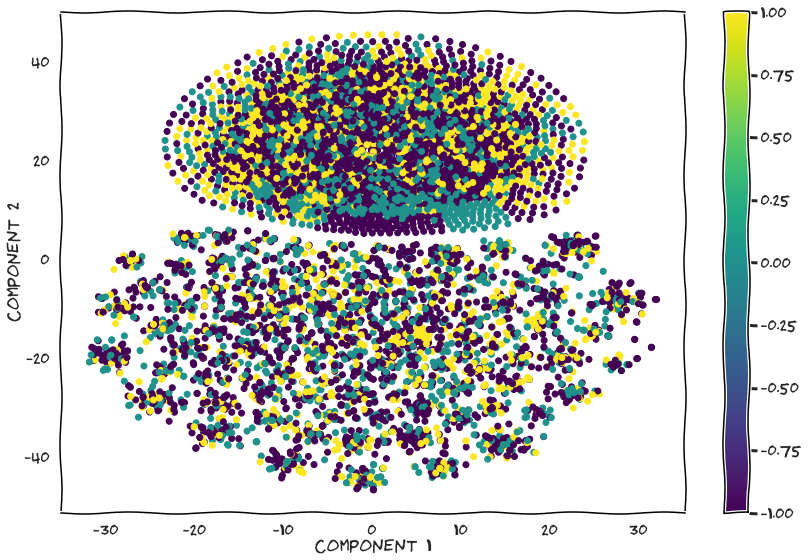

In [ ]:
# Previous trial spikes

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  # x = np.linspace(0,4,100)
  # y = a*x +b
  # plt.plot(x,y,'-r',label='y=1.5x-20')
  
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  if show:
    plt.show()


# Visualize the data
with plt.xkcd():
  visualize_components(embed_prev[:, 0], embed_prev[:, 1], uc_responses_current_trial)

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed_prev_lesspoints = tsne_model.fit_transform(uc_spikes_prev_trial[::10])

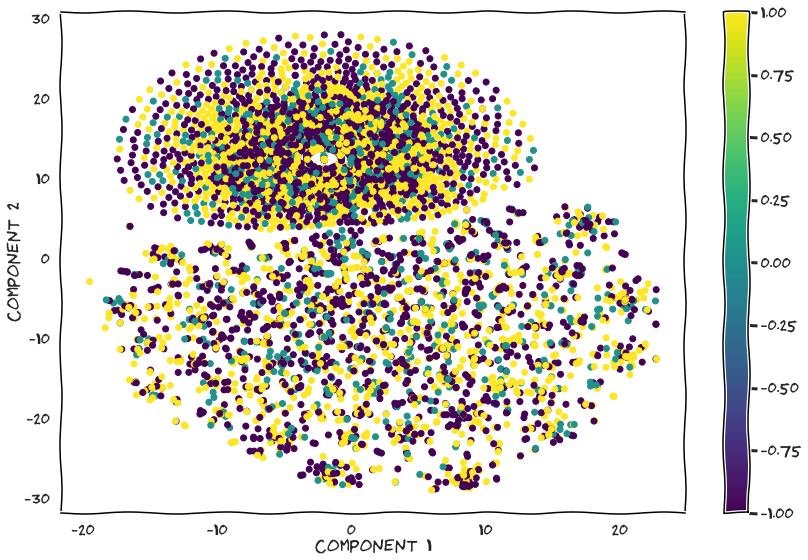

In [ ]:
# Previous trial spikes

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  # x = np.linspace(0,4,100)
  # y = a*x +b
  # plt.plot(x,y,'-r',label='y=1.5x-20')
  
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  if show:
    plt.show()


# Visualize the data
with plt.xkcd():
  visualize_components(embed_prev_lesspoints[:, 0], embed_prev_lesspoints[:, 1], uc_responses_current_trial[::10])

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed_prev = tsne_model.fit_transform(uc_spikes_prev_trial)

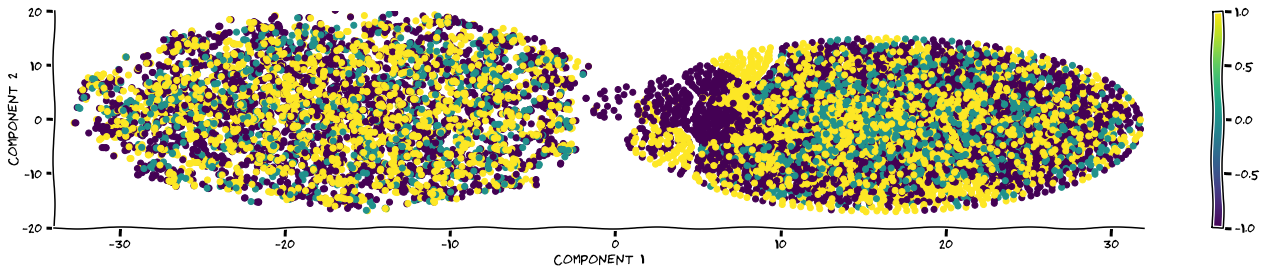

In [ ]:
def visualize_components(a,b,c,d,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  # x = np.linspace(0,4,1000)
  # y = a*x +b
  # plt.plot(x,y,'-r',label='y=1.5x-20')
  
  # x = np.linspace(0,4,1000)
  # y = c*x +d
  # plt.plot(x,y,'-r',label='y=1.5x-20')

  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.xlim(-34, 32)
  plt.ylim(-20, 20)
  if show:
    plt.show()

#higher line
a = 15
b = 25

#lower line
c = 3
d =-20

# Visualize the data
with plt.xkcd():
  visualize_components(a, b, c, d,embed_prev[:, 0], embed_prev[:, 1], uc_responses_current_trial)

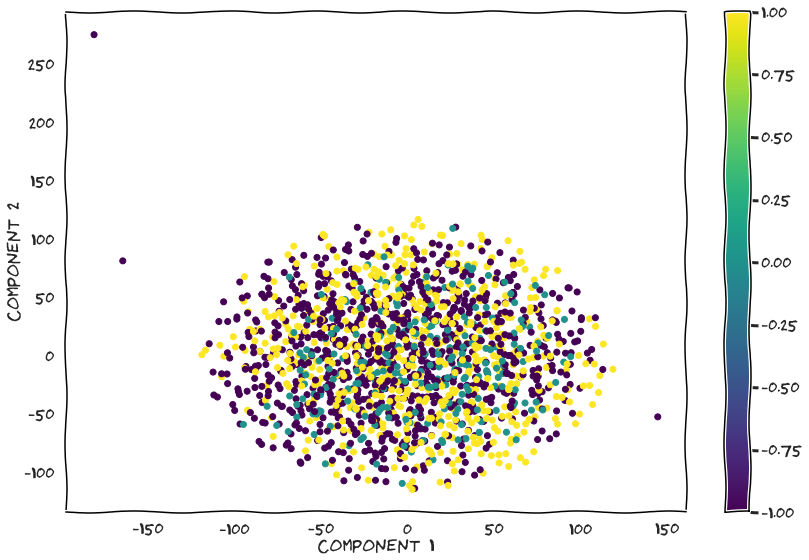

In [ ]:
from sklearn.manifold import TSNE
tsne_model_perplex_100 = TSNE(n_components=3, perplexity=30, random_state=2020)

# Perform t-SNE
embed_prev_perplex_100 = tsne_model_perplex_100.fit_transform(uc_spikes_prev_trial[::10])

def visualize_components(a,b,c,d,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,1000)
  y = a*x +b
  #plt.plot(x,y,'-r',label='y=1.5x-20')
  
  x = np.linspace(0,4,1000)
  y = c*x +d
  #plt.plot(x,y,'-r',label='y=1.5x-20')

  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  if show:
    plt.show()

#higher line
a = 15
b = 25

#lower line
c = 3
d =-20

# Visualize the data
with plt.xkcd():
  visualize_components(a, b, c, d,embed_prev_perplex_100[:, 2], embed_prev_perplex_100[:, 0], uc_responses_current_trial[::10])

# Getting the filtered data in between the two lines

In [ ]:
#higher line
a = 15
b = 25

#lower line
c = 3
d =-20

#indexing_prev = (embed_prev[:,1] < a*embed_prev[:,0]+b) & (embed_prev[:,1] > c*embed_prev[:,0]+d)
indexing_prev = (embed_prev[:,1] < a*embed_prev[:,0]+b)
filtered_spks_previous = uc_spikes_prev_trial[indexing_prev]
filtered_labels_current = uc_responses_current_trial[indexing_prev]

In [ ]:
np.shape(embed_prev[:,0])

(5166,)

Isobel's logistic regression on filtered previous trial spikes

In [ ]:
# choose the brain region of interest
region = 'AUD'
# PL, ILA, ACA; CP, ACB, GPe, SCm, SCs
# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_prev = []
uc_trial_response = []
uc_previous_trial_response = []
uc_previous_trial_spk = []
#current
uc_current_trial_spk = []
uc_current_trial_response = []

# for each session within the spiking array:
for dat in range(len(visr_ls)):
  # identify trials that are 'uncertain' and put response on that trial into a vector
  #uncertain_trial_idx = np.equal(visl_ls[dat], visr_ls[dat])*(visr_ls[dat]!=0)
  uncertain_trial_idx =  np.where((visr_ls[dat]==visl_ls[dat]) & (visl_ls[dat]!=0))
  prev_trial_idx = uncertain_trial_idx[0] - 1
  #current
  curr_trial_idx = uncertain_trial_idx[0]
  uc_trial_response.append(response_ls[dat][uncertain_trial_idx[0]])
  uc_previous_trial_response.append(response_ls[dat][prev_trial_idx])
  #current
  uc_current_trial_response.append(response_ls[dat][curr_trial_idx])
  # with the logical index of uncertain trials, pull out spikes from the trial BEFORE all the uncertain trials
  uc_previous_trial_spk.append(spks_ls[dat][:,prev_trial_idx,:])
  #current
  uc_current_trial_spk.append(spks_ls[dat][:,curr_trial_idx,:])

  # generate a trial response vector that is as long as spikes x trials, for every session

uc_trial_response_repeats = []
uc_previous_trial_response_repeats = []
#current
uc_current_trial_response_repeats = []

for dat in range(len(visr_ls)):
  uc_trial_response_repeats.append(np.repeat(uc_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  uc_previous_trial_response_repeats.append(np.repeat(uc_previous_trial_response[dat],np.shape(uc_previous_trial_spk[dat])[0]))
  #current
  uc_current_trial_response_repeats.append(np.repeat(uc_current_trial_response[dat],np.shape(uc_current_trial_spk[dat])[0]))

uc_trial_response_repeats_stacked = np.hstack(uc_trial_response_repeats)
uc_previous_trial_response_repeats_stacked = np.hstack(uc_previous_trial_response_repeats)
#current
uc_current_trial_response_repeats_stacked = np.hstack(uc_current_trial_response_repeats)

uc_previous_trial_spk_stacked = []
#current
uc_current_trial_spk_stacked = []
for dat in range(len(visr_ls)):
  uc_previous_trial_spk_stacked.append(np.vstack(uc_previous_trial_spk[dat]))
  #current
  uc_current_trial_spk_stacked.append(np.vstack(uc_current_trial_spk[dat]))

In [ ]:
to_shuffle_filtered_labels_current = filtered_labels_current
np.random.shuffle(to_shuffle_filtered_labels_current)

n_scores = []


train_x, test_x, train_y, test_y = train_test_split(filtered_spks_previous, to_shuffle_filtered_labels_current, train_size=0.8)

logmodel = LogisticRegression(multi_class= 'multinomial', random_state=1, max_iter = 500).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


Mean Accuracy: 0.510 (0.001)


In [ ]:
print(f'Left choices: {np.sum(to_shuffle_filtered_labels_current==1)/len(to_shuffle_filtered_labels_current)}')
print(f'Right choices: {np.sum(to_shuffle_filtered_labels_current==-1)/len(to_shuffle_filtered_labels_current)}')
print(f'None choices: {np.sum(to_shuffle_filtered_labels_current==0)/len(to_shuffle_filtered_labels_current)}')

Left choices: 0.34753263996459394
Right choices: 0.5104005310909493
None choices: 0.14206682894445674


In [ ]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


n_scores = []


train_x, test_x, train_y, test_y = train_test_split(filtered_spks_previous, filtered_labels_current, train_size=0.8)

logmodel = LogisticRegression(multi_class= 'multinomial', random_state=1, max_iter = 500).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.532 (0.013)


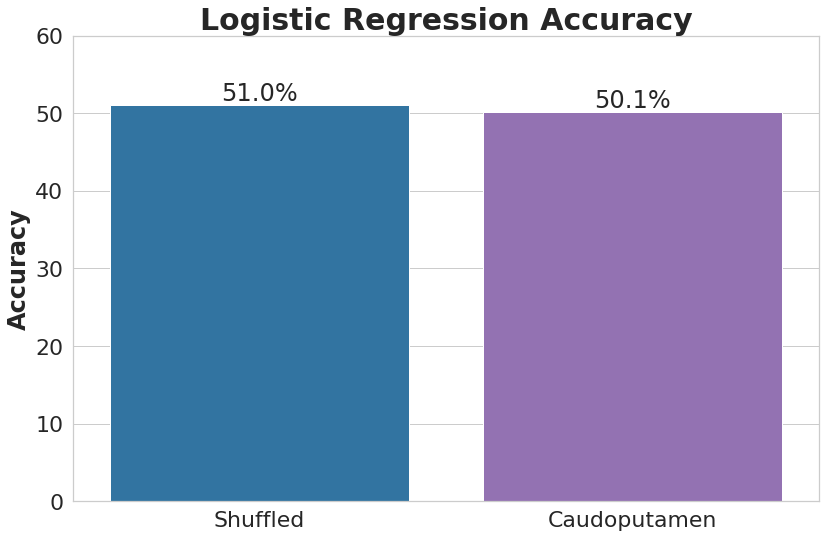

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.set(font_scale = 2)
sns.set_style("whitegrid") 
ax = sns.barplot(x = ['Shuffled','Caudoputamen'], y = [51,50.1],palette=("tab:blue","tab:purple"))
#ax = sns.countplot(x="Prev_Resp1_Words",data=Right_UncertainID,palette=("tab:blue","tab:purple","tab:red"))

ax.set_title('Logistic Regression Accuracy',size=30,weight='bold')
ax.set_ylabel('Accuracy',size=24,weight='bold')
ax.set_ylim(0,60)
#ax.text(50, 850, ". Data: (1, 5)")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(y), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text



#plt.bar(x = ['Chance','Caudoputamen'], height = [33.33,50.1])


In [ ]:
ax

# TSNE on Current trial spikes

In [ ]:
# Current trial spikes

def visualize_components(a,b,c,d,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,100)
  y = a*x +b
  plt.plot(x,y,'-r',label='y=1.5x-20')
  
  x = np.linspace(0,4,100)
  y = c*x +d
  plt.plot(x,y,'-r',label='y=1.5x-20')
  
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.ylim(-5, 10)
  if show:
    plt.show()

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed = tsne_model.fit_transform(uc_spikes_curr_trial)

# Visualize the data
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1], uc_responses_current_trial)

TypeError: ignored

In [ ]:
def visualize_components(a,b,c,d,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,100)
  y = a*x +b
  plt.plot(x,y,'-r',label='y=1.5x-20')
  
  x = np.linspace(0,4,100)
  y = c*x +d
  plt.plot(x,y,'-r',label='y=1.5x-20')
  
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.ylim(-5, 10)
  if show:
    plt.show()

a = 0
b = 8
c = 0
d = -1

# Visualize the data
with plt.xkcd():
  visualize_components(a,b,c,d,embed[:, 0], embed[:, 1], uc_responses_current_trial)

## Getting the filtered data between the two lines

In [ ]:
indexing = (embed[:,1] < a*embed[:,0]+b) & (embed[:,1] > c*embed[:,0]+d)
filtered_spks_current = uc_spikes_curr_trial[indexing]
filtered_labels_current = uc_responses_current_trial[indexing]

## Isobel's logistic regression code on "filtered" current trial spike data 62.7% accuracy!!


In [ ]:
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


n_scores = []


train_x, test_x, train_y, test_y = train_test_split(filtered_spks_current, filtered_labels_current, train_size=0.8)

logmodel = LogisticRegression(multi_class= 'multinomial', random_state=1, max_iter = 500).fit(train_x, train_y)
logmodel.predict(test_x)
logmodel.predict_proba(test_x)
logmodel.score(test_x,test_y)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores.append(cross_val_score(logmodel, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1))

print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# PCA on new variables

In [ ]:
uc_spikes_prev_trial
uc_spikes_curr_trial
uc_responses_current_trial
uc_responses_previous_trial

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.ndimage.filters import gaussian_filter1d
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def z_score(X):
    # X: ndarray, shape (n_features, n_samples)
    ss = StandardScaler(with_mean=True, with_std=True)
    Xz = ss.fit_transform(X.T).T
    return Xz

X = uc_spikes_prev_trial # data array of shape n_neuron by n_time_points
X = z_score(X)
c = np.cov(X, rowvar=True) # covariance matrix
eig_vals, eig_vecs = np.linalg.eig(c)
srt = np.argsort(eig_vals)[::-1]
print('Sorted eigenvalues: \n{}'.format(eig_vals[srt]))
print('\nFirst eigenvector: \n{}'.format(eig_vecs[:, srt][:, 0]))

In [ ]:
Xr_sc = z_score(uc_responses_previous_trial)

pca = PCA(n_components=15)
Xp = pca.fit_transform(Xr_sc.T).T

projections = [(0, 1), (1, 2), (0, 2)]
fig, axes = plt.subplots(1, 3, figsize=[9, 3], sharey='row', sharex='row')
for ax, proj in zip(axes, projections):
    for t, t_type in enumerate(trial_types):
        x = Xp[proj[0], t_type_ind[t]]
        y = Xp[proj[1], t_type_ind[t]]
        ax.scatter(x, y, c=pal[t], s=25, alpha=0.8)
        ax.set_xlabel('PC {}'.format(proj[0]+1))
        ax.set_ylabel('PC {}'.format(proj[1]+1))
sns.despine(fig=fig, top=True, right=True)
add_orientation_legend(axes[2])

# TSNE with variables seperated by arrays of -1, 0, 1

In [ ]:
#2020
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed = tsne_model.fit_transform(manifold_spks[::10])

# Visualize the data
with plt.xkcd():
  visualize_components(embed[:, 0], embed[:, 1], manifold_labels[::10])

In [ ]:
def visualize_components(a,b,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,100)
  y = a*x +b
  plt.plot(x,y,'-r',label='y=1.5x-20')

  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.xlim(-10, 10)
  plt.ylim(-10, 10)
  if show:
    plt.show()

#2020
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed_2020 = tsne_model.fit_transform(manifold_spks[::10])

# Visualize the data
a = 3.5
b = -2

with plt.xkcd():
  visualize_components(a, b, embed_2020[:-1, 0], embed_2020[:-1, 1], manifold_labels[::10][1:])

In [ ]:
a = 3.5
b = -2
indexing = embed[:,1] < a*embed[:,0]+b
filtered_spks = manifold_spks[::10][indexing]
filtered_labels = manifold_labels[::10][indexing]

## Full dataset

In [ ]:
#2020
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed = tsne_model.fit_transform(manifold_spks)

NameError: ignored

In [ ]:
from sklearn.manifold import TSNE

# @title Plotting Functions

def visualize_components(a,b,component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,100)
  y = a*x +b
  plt.plot(x,y,'-r',label='y=1.5x-20')

  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap, s=0.5)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  plt.xlim(-25, 30)
  plt.ylim(-50, 50)
  if show:
    plt.show()

    
# Visualize the data
a = 0
b = 0
  
with plt.xkcd():
  visualize_components(a, b, embed[:, 0], embed[:, 1], manifold_labels)

NameError: ignored

In [ ]:
a = 0
b = 0
indexing = embed[:,1] > 0
filtered_spks_prev_all = manifold_spks[indexing]
filtered_labels_prev_all = manifold_labels[indexing]

## tsne on current uncertain neurons

In [ ]:
# choose the brain region of interest
region = 'CP'

# initialize empty lists for variables of interest
visl_ls = []
response_ls = []
visr_ls = []
spks_ls = []
spks_avg = []

# for each session:
for dat in alldat:
  # in a, find neurons in the brain region of interest
  a = dat['spks'][dat['brain_area'] == region]
  # if this session contains neurons from the brain region of interest, start appending its data!
  if len(a) > 0:
    # append the spiking data
    #spks_ls.append(a[:,:,50:90])
    spks_ls.append(a[:,:,50:200])
    # append response data
    response_ls.append(dat['response']) # right - nogo - left (-1, 0, 1)
    # append right  stimulus contrast data
    visr_ls.append(dat['contrast_right']) # 0 - low - high
    # append left stimulus contrast data
    visl_ls.append(dat['contrast_left']) # 0 - low - high

spks_uc_current = []
uc_trial_resp = []

for i,j,k,l in zip(visl_ls, response_ls, visr_ls, spks_ls):
  # left stim => i>0, k==0,  right stim => i==0, k>0
  # taking this mean averages over the trials axis (axis=1) -- will end up with a neurons x timepoints array for 'spks_avg_xx'
  spks_uc_current.append(l[:,(np.logical_and(np.logical_and(i==k, j==j),k!=0))])
  uc_trial_resp.append(j[(np.logical_and(np.logical_and(i==k, j==j),k!=0))])

array_spks = []
array_idx = []
for i in range(len(spks_uc_current)):
  if spks_uc_current[i].size!=0:
    a = np.vstack(spks_uc_current[i])
    b = np.vstack(np.repeat(uc_trial_resp[i],np.shape(spks_uc_current[i])[0]))
    array_spks.append(a)
    array_idx.append(b)
spks_uc_current_all = np.vstack(array_spks)
idx_uc_current_all = np.vstack(array_idx)

spks_uc_current_all_right = spks_uc_current_all[idx_uc_current_all[:,0]==-1]
spks_uc_current_all_left = spks_uc_current_all[idx_uc_current_all[:,0]==1]
spks_uc_current_all_none = spks_uc_current_all[idx_uc_current_all[:,0]== 0]

In [ ]:
#creating an array of all spks
spks_current_all = np.vstack((np.vstack((spks_uc_current_all_right, spks_uc_current_all_left)), spks_uc_current_all_none))

# Creating an array of the labels
label_spks_uc_current_all_right = np.array([-1]*len(spks_uc_current_all_right))
label_spks_uc_current_all_left = np.array([1]*len(spks_uc_current_all_left))
label_spks_uc_current_all_none = np.array([0]*len(spks_uc_current_all_none))
label_current_all = np.hstack((np.hstack((label_spks_uc_current_all_right, label_spks_uc_current_all_left)),label_spks_uc_current_all_none))

#Taking the spks and the corresponding labels
manifold_current_spks, manifold_current_labels = spks_current_all, label_current_all

In [ ]:
from sklearn.manifold import TSNE



#2020
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=2020)

# Perform t-SNE
embed = tsne_model.fit_transform(manifold_current_spks)

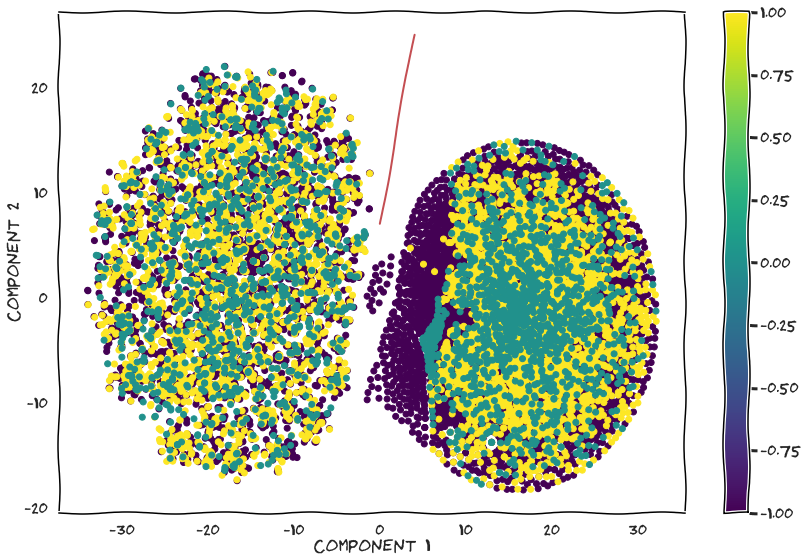

In [ ]:
# @title Plotting Functions

def visualize_components(a, b, component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  
  x = np.linspace(0,4,100)
  y = a*x +b
  plt.plot(x,y,'-r',label='y=1.5x-20')
  
  cmap = plt.cm.get_cmap('viridis')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar()
  plt.clim(-1, 1)
  if show:
    plt.show()


# Visualize the data
a = 4.5
b = 7

with plt.xkcd():
  visualize_components(a, b, embed[:, 0], embed[:, 1], manifold_current_labels)

In [ ]:
a = 4.5
b = 7
indexing = embed[:,1] < a*embed[:,0] + b
filtered_spks_current_all = manifold_current_spks[indexing]
filtered_labels_current_all = manifold_current_labels[indexing]

In [ ]:
filtered_spks_prev_all
filtered_labels_prev_all
filtered_spks_current_all
filtered_labels_current_all

# Don't need these

# Helper codes

In [ ]:
# @title Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(alldat)), dtype=bool)
for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
    yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldat)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
    for area in group:
        ytickobjs[counter].set_color(color)
        counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)

In [ ]:
#@title basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[0]
print(dat.keys())

dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [ ]:
nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [ ]:
#@title plots by brain region and visual conditions
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0, vis_right>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left==0 , vis_right==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_and(vis_left>0, vis_right>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


In [ ]:
#@title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  if np.sum(barea==j)==0:
    continue
  plt.plot(1/dt * dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
  plt.plot(1/dt * dat['spks'][barea==j][:,response>0].mean(axis=(0,1)))
  plt.plot(1/dt * dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
 
  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=12)
  ax.set(xlabel = 'time', ylabel = 'mean firing rate (Hz)')


In [ ]:
#@title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA 

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [ ]:
#@title The top PCs capture most variance across the brain. What do they care about? 
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2,len(pc_10ms)+1,j+1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))
   
  if j==0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)
  
  plt.plot(pc1[response>0, :].mean(axis=0))  
  plt.plot(pc1[response<0, :].mean(axis=0))
  plt.plot(pc1[response==0, :].mean(axis=0))

  if j==0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
  plt.title('PC %d'%j)

In [ ]:
#@title now sort all trials by response latency and see if the PCs care about that.
from scipy.stats import zscore

isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time', ylabel = 'trials sorted by latency')
  plt.title('PC %d'%j)

In [ ]:
#@title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')


In [ ]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1,5,1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel = 'binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1,5,2)
plt.plot(dat['wheel'][0, response>0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Left choices');

ax = plt.subplot(1,5,3)
plt.plot(dat['wheel'][0, response<0].mean(0));
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='Right choices');

ax = plt.subplot(1,5,4)
plt.plot(dat['wheel'][0, response==0].mean(0));
ax.set(ylim=yl, ylabel='wheel turns', xlabel = 'binned time', title='No go choices');


In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1,nareas,j+1)
  plt.title(regions[j])
  
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0, vis_right_p>0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0 , vis_right_p==0)].mean(axis=(0,1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p==0 , vis_right_p==0)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks_passive'][barea==j][:,np.logical_and(vis_left_p>0, vis_right_p>0)].mean(axis=(0,1)))  
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')

In [ ]:
# for more variables check out the additional notebook (load_steinmetz_extra) which includes LFP, waveform shapes and exact spike times (non-binned)